## 1. Data Loading and Initial Exploration

In this section, we'll load the Turkish earthquake dataset from AFAD (Disaster and Emergency Management Presidency) and perform initial exploratory analysis. AFAD is Turkey's official disaster management authority, providing authoritative seismic data.

Our dataset contains earthquake records with magnitude >4.0, which represents seismically significant events that can potentially cause damage to structures. Lower magnitude events (2.0-3.9) are more numerous but less impactful, which is why our analysis focuses on events ≥4.0. The dataset includes:

- **Geographic coordinates**: Longitude and Latitude in decimal degrees using the WGS84 reference system
- **Earthquake characteristics**: 
  - Magnitude (Richter scale/moment magnitude)
  - Depth (km beneath surface)
  - Type (fault mechanism classifications)
- **Temporal information**: Date and time stamps for chronological analysis
- **Location descriptions**: Named regions/cities for geographical context
- **Fault line data**: Vector data of Turkey's active fault systems with importance classifications

The fault line data is particularly valuable as Turkey sits on multiple active fault systems, primarily the North Anatolian Fault (NAF) and East Anatolian Fault (EAF), which are responsible for most major earthquakes in the region.

We'll establish an organized directory structure (maps/, models/, produced_data/) to systematically store our analytical outputs, visualizations, and trained models for reproducibility.

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
from datetime import datetime
import plotly.express as px
import geopandas as gpd
from shapely.geometry import Point, LineString
import math
import os

# Set visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

# Load the earthquake dataset
earthquake_df = pd.read_csv('data\\earthquake_data.csv')

# Load fault line data
fault_gdf = gpd.read_file('data\\tr_faults_imp.geojson')
print(f"Number of fault lines: {len(fault_gdf)}")
print(f"Available properties: {fault_gdf.columns.tolist()}")

# Display first few rows to understand the structure
earthquake_df.head()

Number of fault lines: 926
Available properties: ['fid', 'RATE', 'CONF', 'SENS1', 'SENS2', 'UPSIDE', 'ZONE_NAME', 'FAULT_NAME', 'AUTH', 'PARM', 'TEXT', 'FAULT_ID', 'importance', 'geometry']


,Date,Longitude,Latitude,Depth,Type,Magnitude,Location,EventID,TimeName,TypeName,MagnitudeName
0,12/05/2025 23:30:12,25.7561,36.7292,7.00,MW,4.9,Ege Denizi,661069,AFAD,AFAD,AFAD
1,12/05/2025 09:26:26,35.1944,40.8211,19.00,MW,4.2,Gümüşhacıköy (Amasya),661003,AFAD,AFAD,AFAD
2,12/05/2025 09:23:55,35.1919,40.8150,10.07,MW,4.4,Gümüşhacıköy (Amasya),661002,AFAD,AFAD,AFAD
3,03/05/2025 23:53:41,28.9431,39.2400,12.55,ML,4.0,Simav (Kütahya),660145,AFAD,AFAD,AFAD
4,02/05/2025 12:51:15,28.9989,39.2233,12.55,MW,4.2,Simav (Kütahya),659964,AFAD,AFAD,AFAD


In [40]:
# Basic information about the dataset
print(f"Dataset shape: {earthquake_df.shape}")
print(f"Number of earthquakes: {len(earthquake_df)}")
print("\nData types:")
print(earthquake_df.dtypes)

# Check for missing values
print("\nMissing values:")
print(earthquake_df.isnull().sum())

# Basic statistics
print("\nBasic statistics:")
earthquake_df.describe()

os.makedirs("maps", exist_ok=True)
os.makedirs("models", exist_ok=True)
os.makedirs("produced_data", exist_ok=True)

print("Created output directories: maps, models, produced_data")

Dataset shape: (11166, 11)
Number of earthquakes: 11166

Data types:
Date              object
Longitude        float64
Latitude         float64
Depth            float64
Type              object
Magnitude        float64
Location          object
EventID            int64
TimeName          object
TypeName          object
MagnitudeName     object
dtype: object

Missing values:
Date             0
Longitude        0
Latitude         0
Depth            0
Type             0
Magnitude        0
Location         0
EventID          0
TimeName         0
TypeName         0
MagnitudeName    0
dtype: int64

Basic statistics:
Created output directories: maps, models, produced_data


## 2. Exploratory Data Analysis (EDA)

### 2.1 Temporal Feature Creation

Converting raw datetime information into structured temporal features enables detection of cyclical patterns and long-term trends in seismic activity. This process, known as datetime feature engineering, is essential for time series analysis of earthquake occurrences.

We'll extract:
- **Calendar components**: Year, month, day, and day of week from timestamps
- **Seasonal classifications**: Winter (Dec-Feb), Spring (Mar-May), Summer (Jun-Aug), Fall (Sep-Nov)

These derived temporal features allow us to:
- Analyze periodicity in seismic activity (potential seasonal correlations)
- Detect long-term increasing/decreasing trends in earthquake frequency
- Identify anomalous periods with unusually high/low activity
- Prepare time-based features for machine learning models

While earthquakes are primarily driven by tectonic forces, seasonal factors like groundwater variations, reservoir levels, and even atmospheric pressure changes have been hypothesized to influence triggering mechanisms for earthquakes that are already near their critical stress threshold. These temporal features will help us investigate such potential correlations.

In [41]:
# Convert Date column to datetime format with explicit format
earthquake_df['Date'] = pd.to_datetime(earthquake_df['Date'], format="%d/%m/%Y %H:%M:%S", errors='coerce')

# Check if any dates couldn't be parsed
null_dates = earthquake_df['Date'].isnull().sum()
print(f"Number of dates that couldn't be parsed: {null_dates}")

# If we have null dates, we can try alternate formats
if null_dates > 0:
    print("Trying alternative date formats...")
    # Try another common format
    earthquake_df['Date'] = pd.to_datetime(earthquake_df['Date'], format="%d-%m-%Y %H:%M:%S", errors='coerce')
    # If still having issues, try auto-detection with dayfirst=True
    if earthquake_df['Date'].isnull().sum() > 0:
        earthquake_df['Date'] = pd.to_datetime(earthquake_df['Date'], dayfirst=True, errors='coerce')
    
    print(f"Remaining null dates after fixes: {earthquake_df['Date'].isnull().sum()}")

# Create additional time-based features
earthquake_df['Year'] = earthquake_df['Date'].dt.year
earthquake_df['Month'] = earthquake_df['Date'].dt.month
earthquake_df['Day'] = earthquake_df['Date'].dt.day
earthquake_df['DayOfWeek'] = earthquake_df['Date'].dt.dayofweek
earthquake_df['Season'] = earthquake_df['Month'].apply(lambda x: 
                                                     'Winter' if x in [12, 1, 2] else
                                                     'Spring' if x in [3, 4, 5] else
                                                     'Summer' if x in [6, 7, 8] else
                                                     'Fall')

# Display the updated dataframe
earthquake_df.head()

Number of dates that couldn't be parsed: 0


,Date,Longitude,Latitude,Depth,Type,Magnitude,Location,EventID,TimeName,TypeName,MagnitudeName,Year,Month,Day,DayOfWeek,Season
0,2025-05-12 23:30:12,25.7561,36.7292,7.00,MW,4.9,Ege Denizi,661069,AFAD,AFAD,AFAD,2025,5,12,0,Spring
1,2025-05-12 09:26:26,35.1944,40.8211,19.00,MW,4.2,Gümüşhacıköy (Amasya),661003,AFAD,AFAD,AFAD,2025,5,12,0,Spring
2,2025-05-12 09:23:55,35.1919,40.8150,10.07,MW,4.4,Gümüşhacıköy (Amasya),661002,AFAD,AFAD,AFAD,2025,5,12,0,Spring
3,2025-05-03 23:53:41,28.9431,39.2400,12.55,ML,4.0,Simav (Kütahya),660145,AFAD,AFAD,AFAD,2025,5,3,5,Spring
4,2025-05-02 12:51:15,28.9989,39.2233,12.55,MW,4.2,Simav (Kütahya),659964,AFAD,AFAD,AFAD,2025,5,2,4,Spring


### 2.2 Geographic Visualization

Creating geographic visualizations is fundamental to understanding the spatial distribution of seismic activity across Turkey's complex tectonic landscape. Interactive maps will reveal patterns that tabular data cannot effectively communicate.

We'll generate:

1. **Earthquake density heatmaps** using kernel density estimation (KDE) to identify hotspots of seismic activity
2. **Magnitude-differentiated markers** for strong earthquakes (magnitude > 6.0), which represent the most destructive events with exponentially higher energy release (~32× more energy per +1.0 magnitude increase)
3. **Fault line overlays** with importance classification, visualizing Turkey's major fault systems like the North Anatolian Fault (NAF) and East Anatolian Fault (EAF)

These visualizations illuminate the spatial relationship between:
- Earthquake epicenters and known fault lines
- Magnitude distribution across different regions
- Clustering patterns of seismic events

Turkey's position at the boundary of the Anatolian, Arabian, and Eurasian tectonic plates creates a complex seismic landscape. Effective visualization of this complexity is crucial for both scientific understanding and risk assessment applications. The interactive maps will allow exploration of these relationships from multiple perspectives.

In [ ]:
# First check and clean coordinate data
print("Coordinate ranges before cleaning:")
print(f"Longitude: {earthquake_df['Longitude'].min()} to {earthquake_df['Longitude'].max()}")
print(f"Latitude: {earthquake_df['Latitude'].min()} to {earthquake_df['Latitude'].max()}")

# Filter out any extreme outliers (coordinates that are clearly wrong)
# Turkey coordinates should be roughly: Longitude 26-45 E, Latitude 36-42 N
valid_coords = (
    (earthquake_df['Longitude'] >= 25) & 
    (earthquake_df['Longitude'] <= 45) & 
    (earthquake_df['Latitude'] >= 35) & 
    (earthquake_df['Latitude'] <= 43)
)

# Filter the dataframe to keep only valid coordinates
clean_df = earthquake_df[valid_coords].copy()
outliers_removed = len(earthquake_df) - len(clean_df)
print(f"Removed {outliers_removed} records with coordinates outside Turkey's boundaries")

print("Coordinate ranges after cleaning:")
print(f"Longitude: {clean_df['Longitude'].min()} to {clean_df['Longitude'].max()}")
print(f"Latitude: {clean_df['Latitude'].min()} to {clean_df['Latitude'].max()}")

# Create a map centered on Turkey
turkey_map = folium.Map(location=[38.5, 35.5], zoom_start=6)

# Sample points for better visualization performance
sample_df = clean_df.sample(min(2000, len(clean_df)))

# Create a heatmap layer with cleaned data
heat_data = [[row['Latitude'], row['Longitude']] for index, row in sample_df.iterrows()]
HeatMap(heat_data, radius=8, gradient={'0.4': 'blue', '0.6': 'cyan', '0.8': 'yellow', '1.0': 'red'}).add_to(turkey_map)

# Add markers for strong earthquakes (magnitude > 6)
for idx, row in clean_df[clean_df['Magnitude'] > 6].iterrows():
    # Create enhanced popup content with styled HTML
    popup_content = f"""
    <div style="font-family: Arial; min-width: 200px;">
        <h4 style="margin-bottom: 5px; color: #d32f2f;">Earthquake Details</h4>
        <b>Magnitude:</b> {row['Magnitude']:.1f}<br>
        <b>Depth:</b> {row['Depth']:.1f} km<br>
        <b>Date:</b> {row['Date']}<br>
        <b>Location:</b> {row['Location']}<br>
    """
    
    # Add type information if available
    if 'Type' in row:
        popup_content += f"<b>Type:</b> {row['Type']}<br>"
    
    # Add additional information if available  
    if 'TypeName' in row and not pd.isna(row['TypeName']):
        popup_content += f"<b>Type Description:</b> {row['TypeName']}<br>"
        
    # Add EventID if available
    if 'EventID' in row and not pd.isna(row['EventID']):
        popup_content += f"<b>Event ID:</b> {row['EventID']}<br>"
    
    popup_content += "</div>"
    
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=row['Magnitude'] * 1.5,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        popup=folium.Popup(popup_content, max_width=300),
    ).add_to(turkey_map)

# Add fault lines to the map
def add_faults_to_map(map_obj, fault_gdf, importance_threshold=0):
    # Filter faults by importance if desired
    if importance_threshold > 0:
        fault_data = fault_gdf[fault_gdf['importance'] >= importance_threshold]
    else:
        fault_data = fault_gdf
    
    # Color by importance
    def style_function(feature):
        importance = feature['properties']['importance']
        color = '#FF0000' if importance >= 4 else '#FFA500' if importance >= 3 else '#FFFF00'
        return {
            'color': color,
            'weight': importance * 0.5,
            'opacity': 0.7
        }
    
    # Add GeoJSON to map
    folium.GeoJson(
        fault_data,
        name='Fault Lines',
        style_function=style_function,
        tooltip=folium.GeoJsonTooltip(fields=['FAULT_NAME', 'importance']),
    ).add_to(map_obj)
    
    return map_obj

# Add fault lines to the map
turkey_map = add_faults_to_map(turkey_map, fault_gdf, importance_threshold=3)

# Add a tile layer for better visualization
folium.TileLayer('cartodbpositron').add_to(turkey_map)

# Add a legend for the map
legend_html = '''
<div style="position: fixed; bottom: 20px; right: 20px; width: 200px; height: auto; 
    background-color: white; border:2px solid grey; z-index:9999; font-size:12px;
    padding: 10px; border-radius: 5px;">
    <p><b>Earthquake Map Legend</b></p>
    <p><i class="fa fa-circle" style="color:red"></i> Magnitude > 6</p>
    <div style="margin-top:5px;">
      <p><b>Heatmap Intensity:</b></p>
      <div style="display:inline-block; height:15px; width:30px; background:blue;"></div>
      <div style="display:inline-block; height:15px; width:30px; background:cyan;"></div>
      <div style="display:inline-block; height:15px; width:30px; background:yellow;"></div>
      <div style="display:inline-block; height:15px; width:30px; background:red;"></div>
      <p style="font-size:10px;">Low &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; High</p>
    </div>
    <div style="margin-top:5px;">
      <p><b>Fault Line Importance:</b></p>
      <p><span style="color:#FF0000;">━━━</span> High (4+)</p>
      <p><span style="color:#FFA500;">━━━</span> Medium (3)</p>
      <p><span style="color:#FFFF00;">━━━</span> Low (<3)</p>
    </div>
</div>
'''
turkey_map.get_root().html.add_child(folium.Element(legend_html))

# Save map to HTML file to view it
turkey_map.save('maps/earthquake_map.html')

Coordinate ranges before cleaning:
Longitude: 23.925 to 45.48
Latitude: 34.6998 to 42.7912
Removed 1337 records with coordinates outside Turkey's boundaries
Coordinate ranges after cleaning:
Longitude: 25.0 to 45.0
Latitude: 35.0 to 42.7912


### 2.3 Temporal Analysis

Analyzing earthquake patterns across different timescales reveals both long-term trends and cyclical behaviors in seismic activity. This multiscale temporal analysis is essential for understanding the time-variant nature of earthquake occurrences.

We'll examine:

1. **Yearly frequency distribution**: Plotted as time series and histogram to identify long-term trends and potential periods of increased activity that might correlate with major tectonic adjustments
   
2. **Seasonal variation**: Aggregating earthquakes by season to detect potential patterns related to environmental factors like precipitation, groundwater levels, or reservoir loading
   
3. **Monthly patterns**: Finer-grained analysis to identify monthly anomalies and verify any apparent seasonal effects

The statistical significance of any observed temporal patterns will be evaluated, as distinguishing between random fluctuations and meaningful patterns is critical in seismological analysis. While the primary drivers of earthquakes are tectonic stresses that accumulate over decades or centuries, short-term variations in frequency can provide insights into triggering mechanisms.

Understanding these temporal patterns contributes to both the scientific knowledge base and potentially to improved forecasting methodologies, though it's important to note that precise earthquake prediction remains beyond current scientific capabilities.

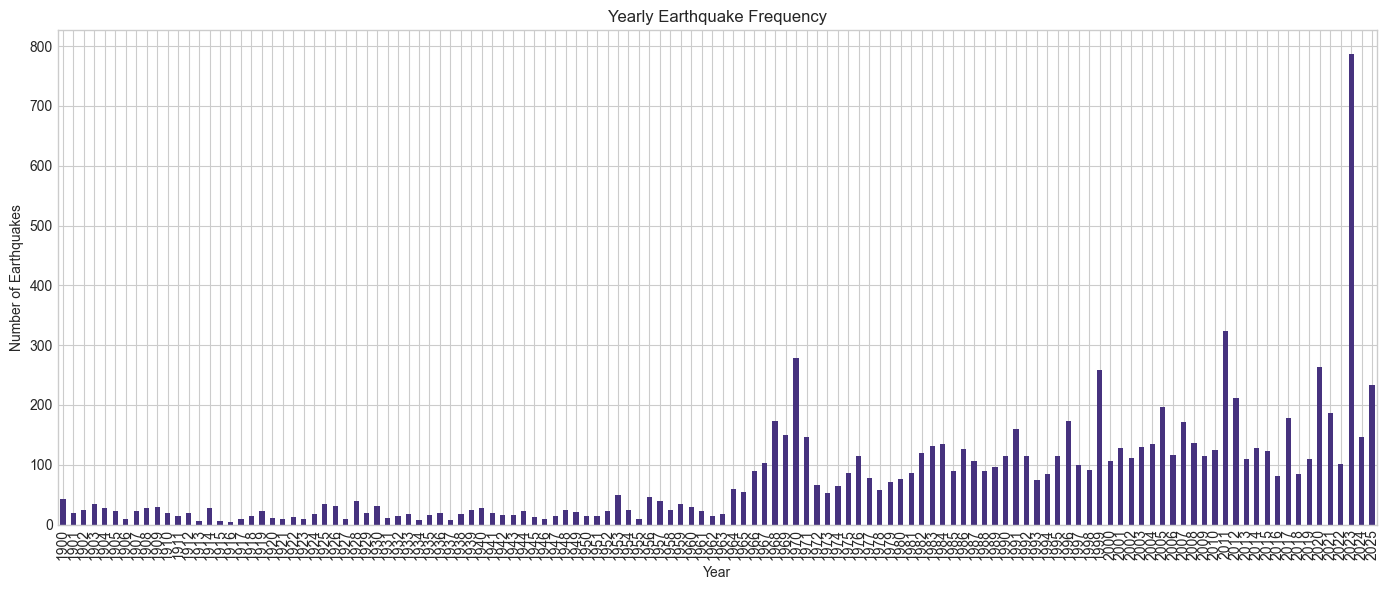

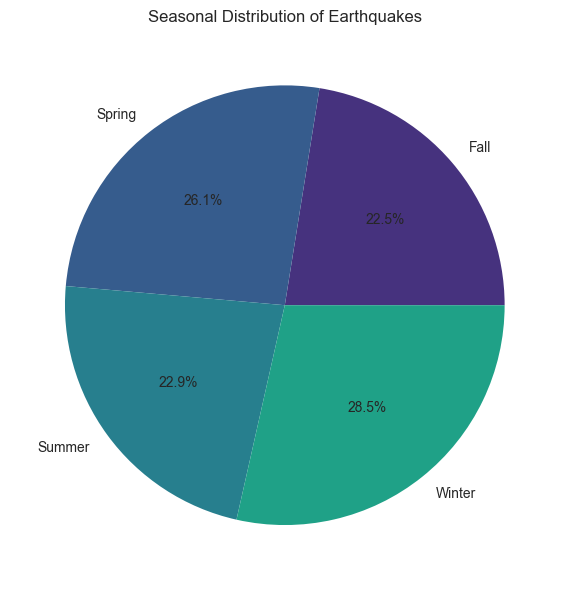

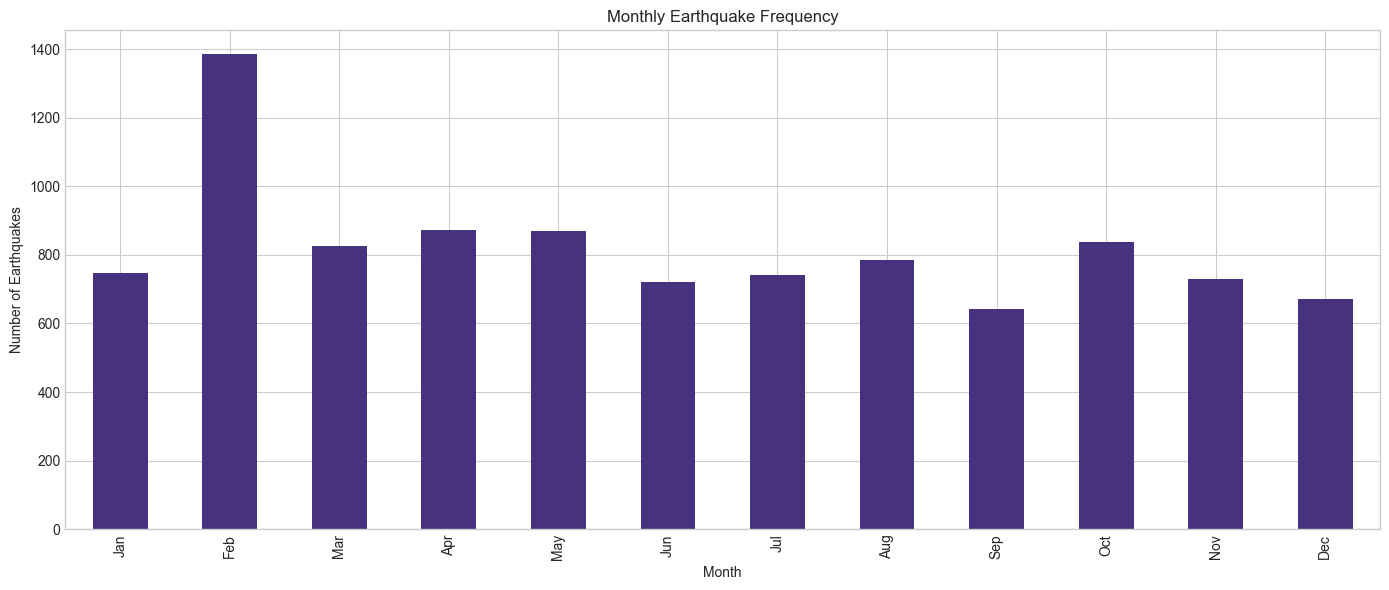

In [43]:
# Use the cleaned dataframe for temporal analysis
# Yearly earthquake frequency
yearly_counts = clean_df.groupby('Year').size()

plt.figure(figsize=(14, 6))
yearly_counts.plot(kind='bar')
plt.title('Yearly Earthquake Frequency')
plt.xlabel('Year')
plt.ylabel('Number of Earthquakes')
plt.tight_layout()
plt.show()

# Seasonal patterns
seasonal_counts = clean_df.groupby('Season').size()

plt.figure(figsize=(10, 6))
seasonal_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title('Seasonal Distribution of Earthquakes')
plt.ylabel('')
plt.tight_layout()
plt.show()

# Monthly patterns
monthly_counts = clean_df.groupby('Month').size()

plt.figure(figsize=(14, 6))
monthly_counts.plot(kind='bar')
plt.title('Monthly Earthquake Frequency')
plt.xlabel('Month')
plt.ylabel('Number of Earthquakes')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.tight_layout()
plt.show()

### 2.4 Magnitude and Depth Analysis

Examining the distribution of earthquake magnitudes and depths provides critical insight into the mechanical properties of Turkey's seismic system. These parameters directly relate to the physics of earthquake generation and propagation.

Our analysis will focus on:

1. **Magnitude distribution**: Visualizing the Gutenberg-Richter relationship, which typically follows a power-law distribution where frequency decreases exponentially as magnitude increases. Deviations from this pattern may indicate catalog incompleteness or unusual seismic characteristics.

2. **Depth distribution**: Analyzing hypocenter depths to understand the vertical structure of seismicity. In Turkey, most earthquakes occur in the upper 30km of crust, but deeper events may indicate different tectonic processes or subduction-related activity.

3. **Magnitude-depth relationships**: Investigating correlations that might reveal whether larger earthquakes systematically occur at specific depths, which relates to the mechanical properties of the crust and stress distribution.

The magnitude scale used (Richter/local magnitude or moment magnitude) is logarithmic, meaning a magnitude 6.0 earthquake releases approximately 32 times more energy than a magnitude 5.0. This exponential relationship dramatically impacts potential damage and is crucial for risk assessment.

Depth analysis is equally important, as shallow earthquakes typically cause more surface damage than deeper events of equivalent magnitude due to reduced wave attenuation and higher peak ground accelerations.

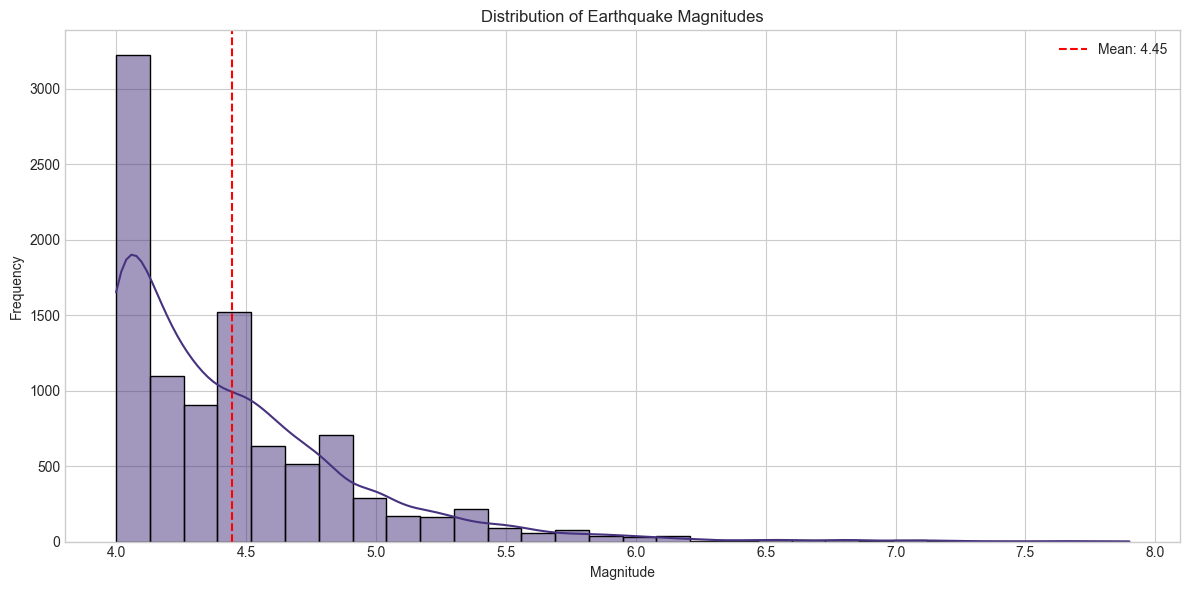

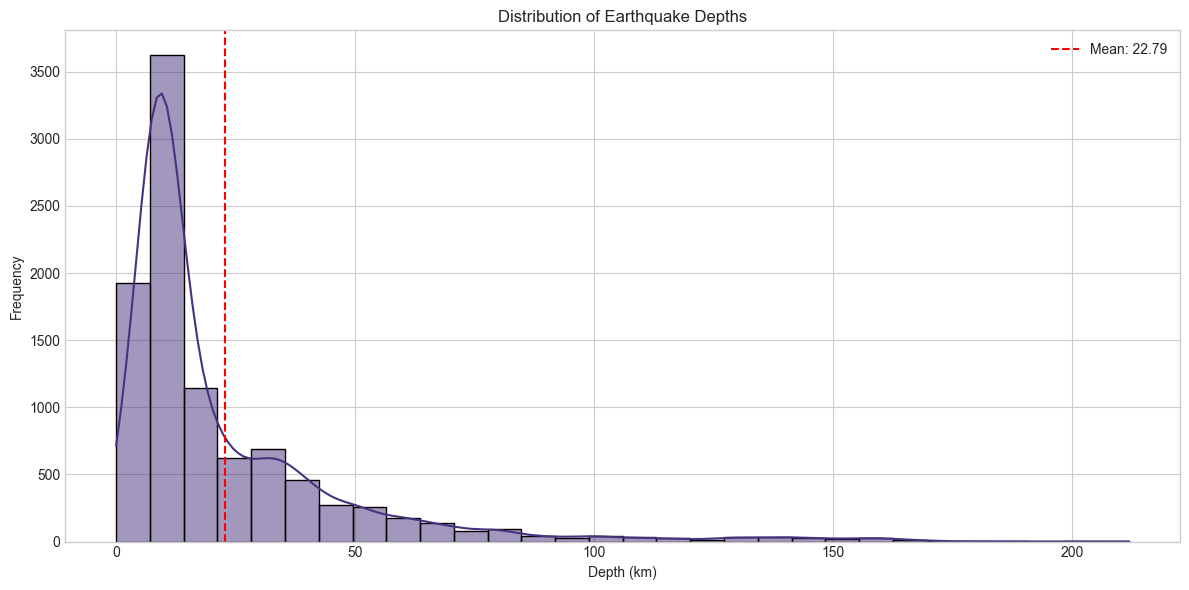

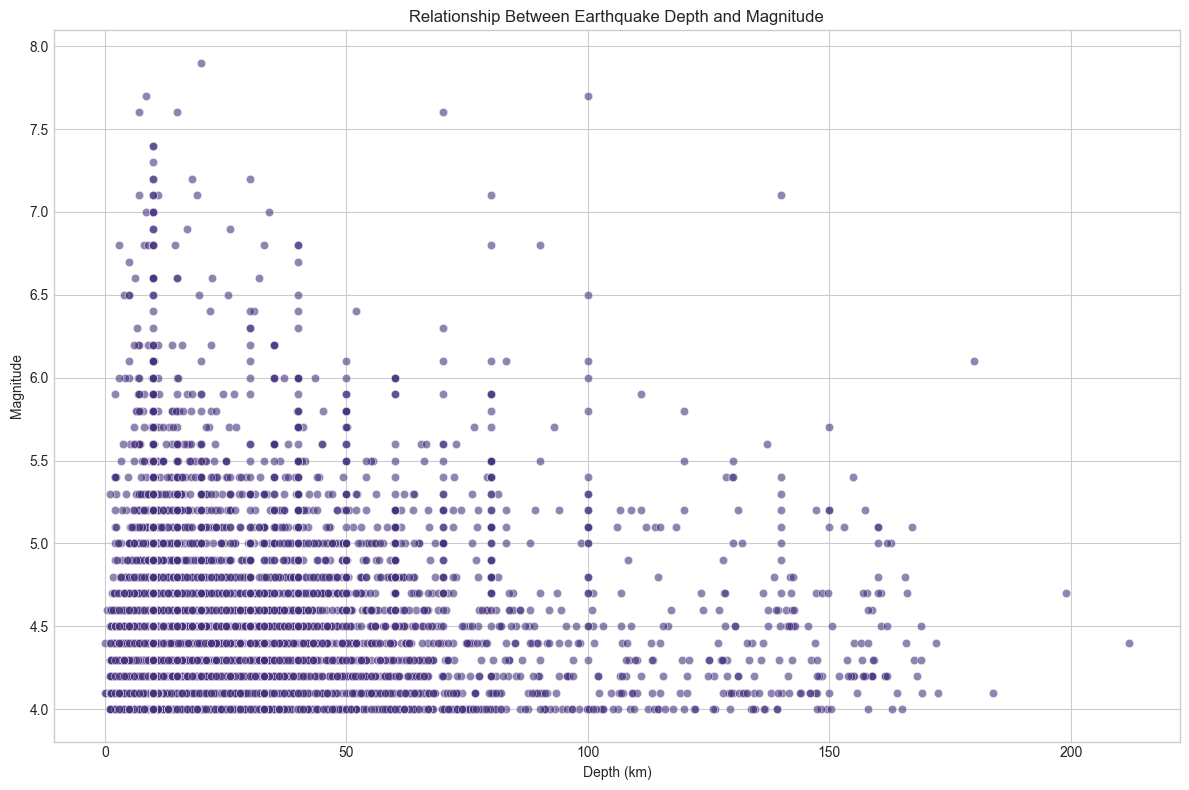

In [44]:
# Magnitude distribution
plt.figure(figsize=(12, 6))
sns.histplot(clean_df['Magnitude'], bins=30, kde=True)
plt.title('Distribution of Earthquake Magnitudes')
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.axvline(clean_df['Magnitude'].mean(), color='red', linestyle='--', label=f'Mean: {clean_df["Magnitude"].mean():.2f}')
plt.legend()
plt.tight_layout()
plt.show()

# Depth distribution
plt.figure(figsize=(12, 6))
sns.histplot(clean_df['Depth'], bins=30, kde=True)
plt.title('Distribution of Earthquake Depths')
plt.xlabel('Depth (km)')
plt.ylabel('Frequency')
plt.axvline(clean_df['Depth'].mean(), color='red', linestyle='--', label=f'Mean: {clean_df["Depth"].mean():.2f}')
plt.legend()
plt.tight_layout()
plt.show()

# Relationship between magnitude and depth
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Depth', y='Magnitude', data=clean_df, alpha=0.6)
plt.title('Relationship Between Earthquake Depth and Magnitude')
plt.xlabel('Depth (km)')
plt.ylabel('Magnitude')
plt.tight_layout()
plt.show()

### 2.5 Correlation Analysis

Exploring statistical relationships between numerical features reveals patterns that can improve our understanding of earthquake characteristics and potentially enhance predictive models. Correlation analysis quantifies these relationships and helps identify the most informative variables.

We'll create a comprehensive correlation matrix to visualize relationships between:

- **Spatial parameters**: Longitude and Latitude correlations may reveal directional trends in seismic activity
- **Physical characteristics**: Relationships between Depth and Magnitude might indicate how energy release varies with crustal depth
- **Temporal-physical interactions**: Correlations between time variables and earthquake properties could suggest seasonal effects on seismic behavior
- **Fault proximity measures**: Correlations between distance to faults and other earthquake parameters

The Pearson correlation coefficient (r) will quantify linear relationships, ranging from -1 (perfect negative correlation) to +1 (perfect positive correlation), with 0 indicating no linear relationship. While correlation doesn't necessarily imply causation, strong correlations can indicate physically meaningful relationships worth further investigation.

For earthquake data specifically, we'll be cautious about interpreting correlations, as seismic processes involve complex, often non-linear interactions. Nonetheless, these correlation patterns can guide feature selection for our machine learning models and help formulate geophysical hypotheses.

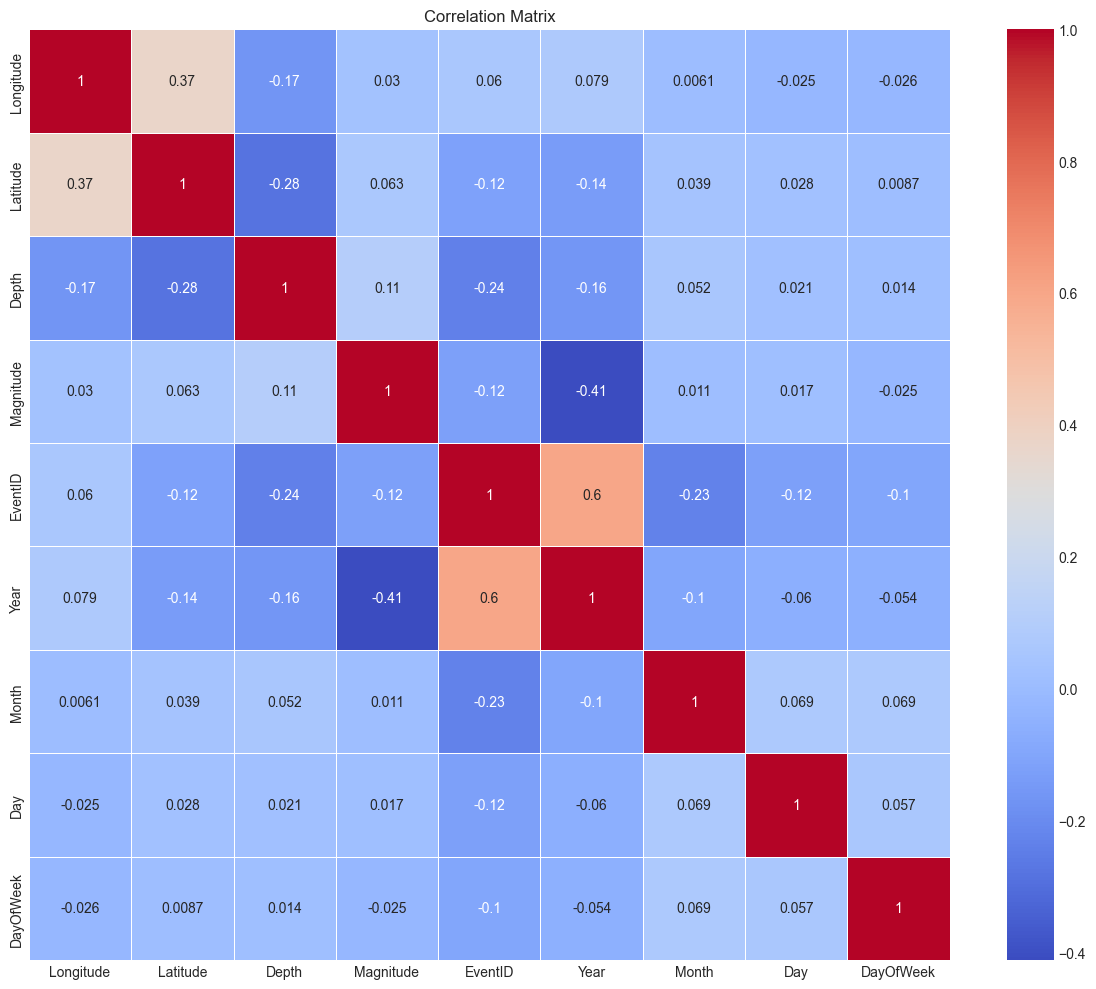

In [45]:
# Correlation analysis of numerical columns
numerical_cols = clean_df.select_dtypes(include=[np.number]).columns
correlation_matrix = clean_df[numerical_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

### 2.6 Additional Visualizations

Further exploration through specialized visualization techniques provides deeper insights into the multidimensional nature of earthquake patterns. These enhanced visualizations go beyond standard plots to reveal complex relationships.

We'll implement:

1. **Magnitude-encoded geographic scatterplots**: Visualizing earthquake locations with color and size encoding for magnitude, revealing spatial patterns in energy release
   
2. **Temporal magnitude boxplots**: Analyzing the distribution of magnitudes across years to identify potential temporal trends in earthquake intensity
   
3. **Depth evolution analysis**: Tracking changes in hypocenter depths over time, which might indicate evolving stress patterns in the crust
   
4. **3D visualization (longitude × latitude × depth)**: Creating interactive three-dimensional plots that represent the true spatial distribution of earthquakes, including their subsurface positions

These advanced visualizations help detect patterns that might be obscured in two-dimensional or non-visual analyses. For example, the 3D visualization allows us to identify potential fault planes in space, as earthquakes often align along these failure surfaces.

Interactive elements in these visualizations enable exploration of the dataset from multiple perspectives, facilitating the discovery of relationships that static visualizations might miss. This multifaceted approach is particularly valuable for complex geophysical data where patterns may exist across multiple dimensions simultaneously.

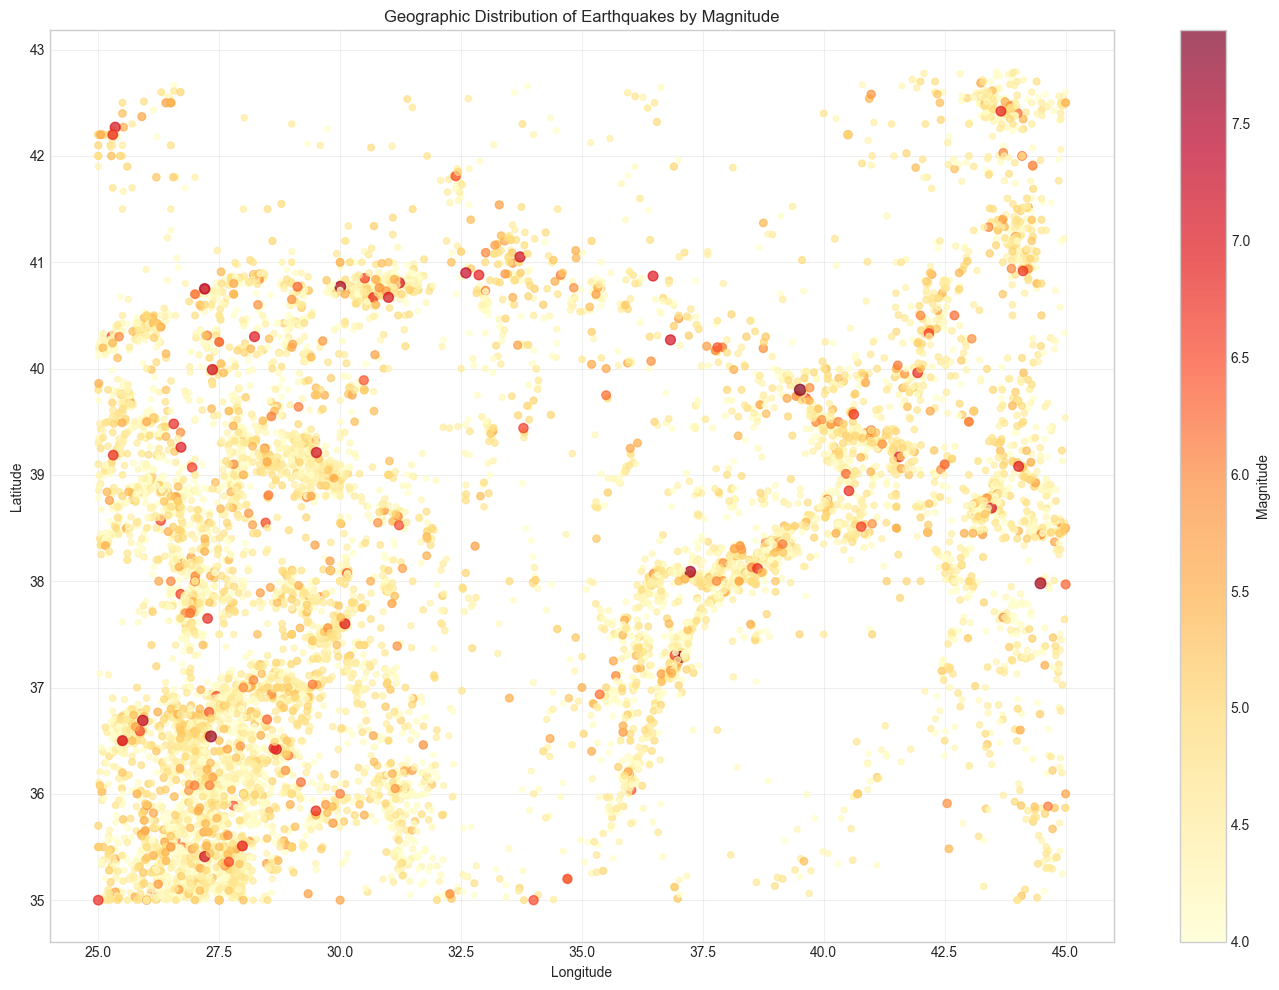

In [46]:
# Geographic distribution by magnitude
plt.figure(figsize=(14, 10))
scatter = plt.scatter(clean_df['Longitude'], clean_df['Latitude'], 
                     c=clean_df['Magnitude'], cmap='YlOrRd', 
                     alpha=0.7, s=clean_df['Magnitude']**2)
plt.colorbar(scatter, label='Magnitude')
plt.title('Geographic Distribution of Earthquakes by Magnitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

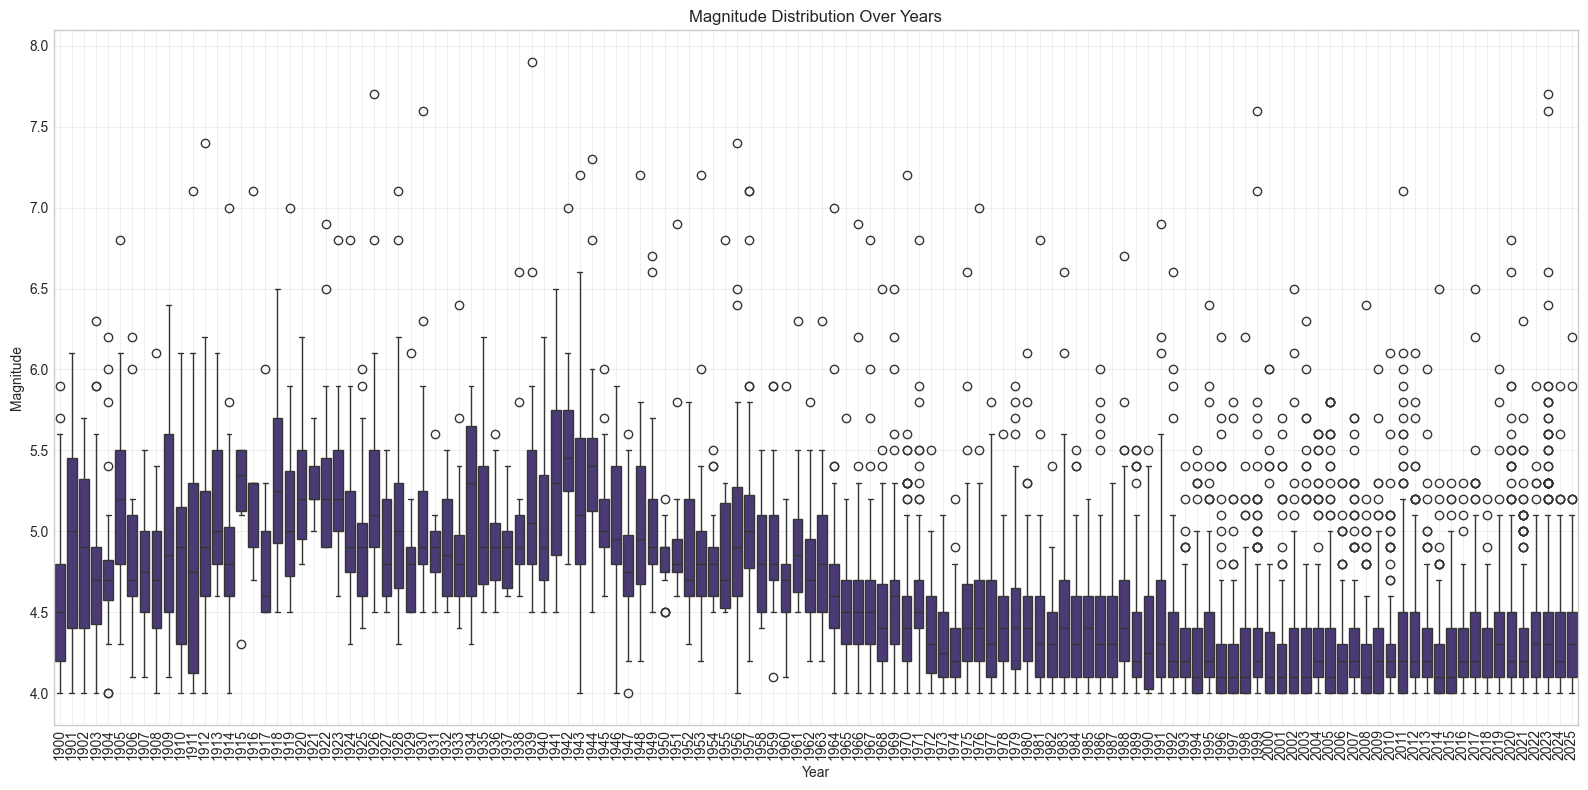

In [47]:
# Magnitude distribution over years (box plot)
plt.figure(figsize=(16, 8))
sns.boxplot(x='Year', y='Magnitude', data=clean_df)
plt.title('Magnitude Distribution Over Years')
plt.xlabel('Year')
plt.ylabel('Magnitude')
plt.xticks(rotation=90)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

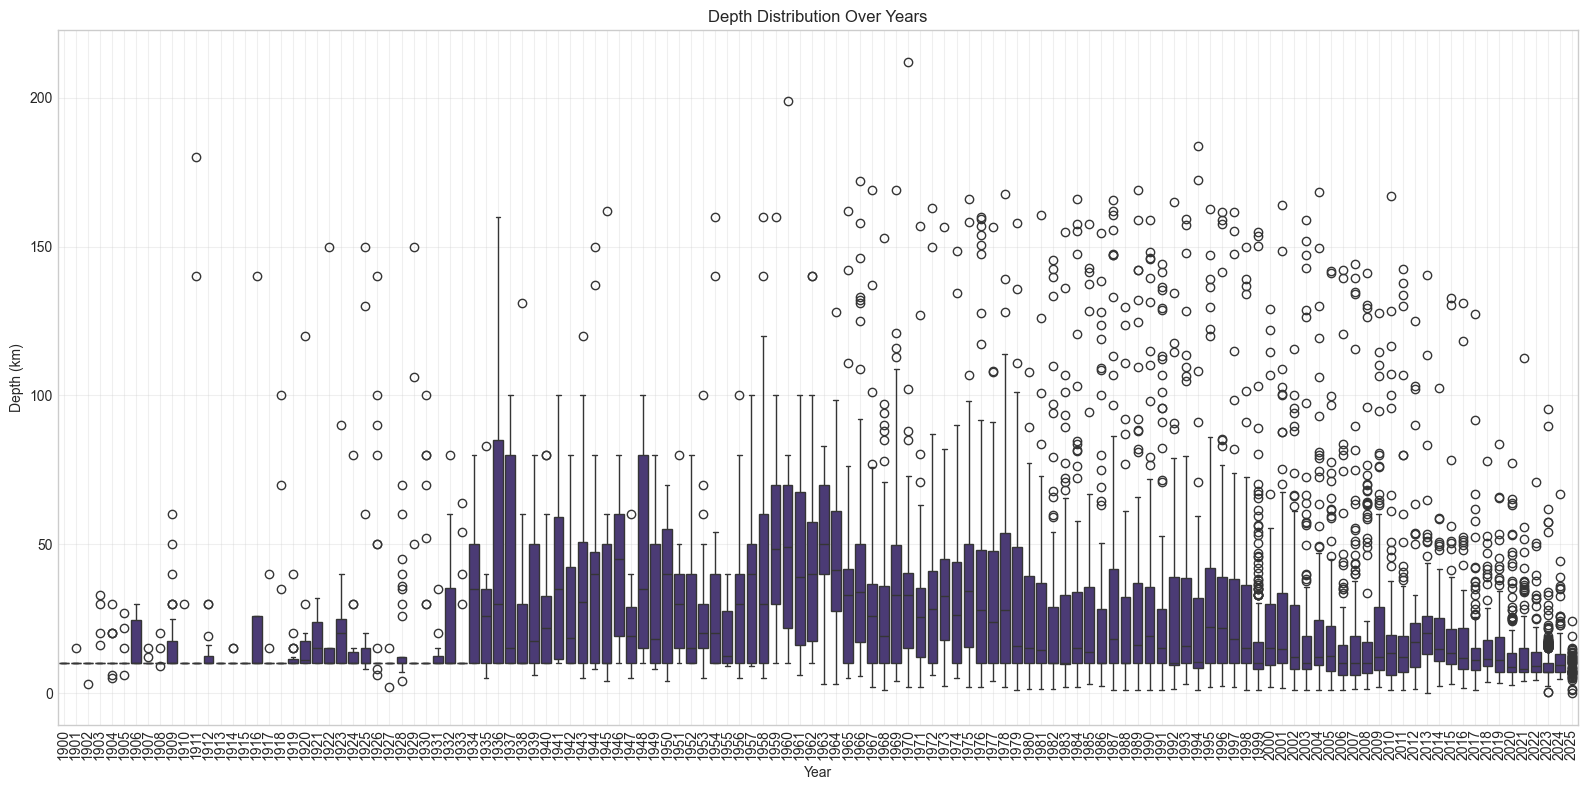

In [48]:
# Depth vs Year analysis
plt.figure(figsize=(16, 8))
sns.boxplot(x='Year', y='Depth', data=clean_df)
plt.title('Depth Distribution Over Years')
plt.xlabel('Year')
plt.ylabel('Depth (km)')
plt.xticks(rotation=90)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# 3D visualization with Plotly
import plotly.express as px

fig = px.scatter_3d(clean_df.sample(min(3000, len(clean_df))), 
                   x='Longitude', y='Latitude', z='Depth',
                   color='Magnitude', size='Magnitude',
                   color_continuous_scale='Viridis',
                   title='3D Visualization of Earthquakes')
# Ensure proper axis orientation
fig.update_layout(scene=dict(
    xaxis_title='Longitude',
    yaxis_title='Latitude',
    zaxis_title='Depth (km)',
    # Reverse the depth axis to show deeper earthquakes lower
    zaxis=dict(autorange="reversed")
))
fig.write_html('maps/earthquake_3d.html')

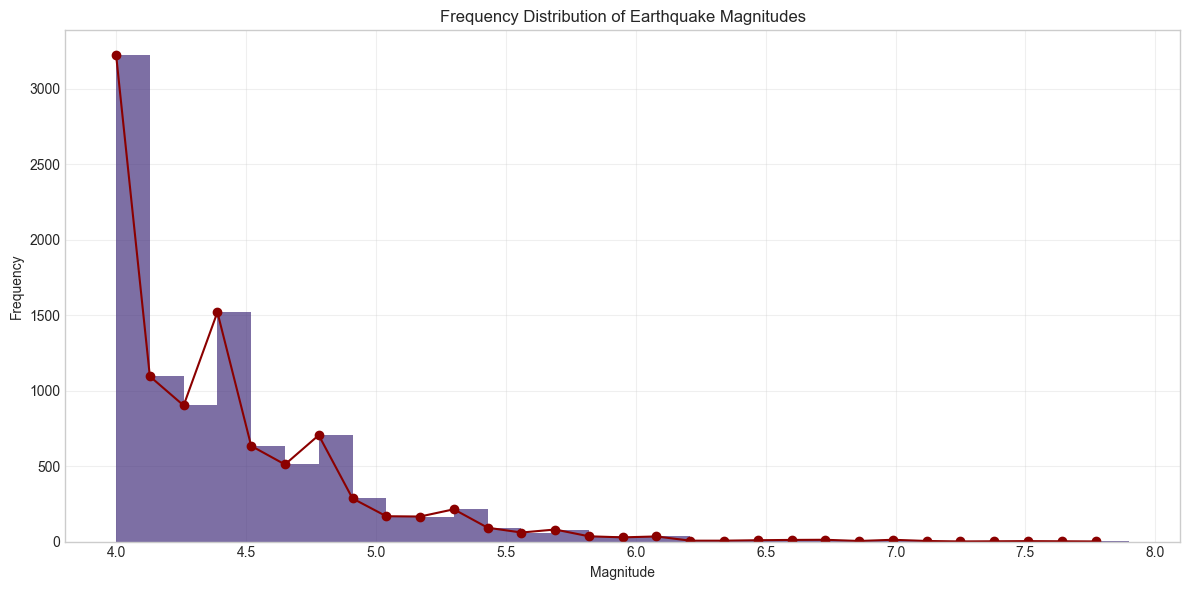

In [50]:
# Magnitude frequency plot
plt.figure(figsize=(12, 6))
counts, bins, _ = plt.hist(clean_df['Magnitude'], bins=30, alpha=0.7)
plt.plot(bins[:-1], counts, '-o', color='darkred')
plt.title('Frequency Distribution of Earthquake Magnitudes')
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

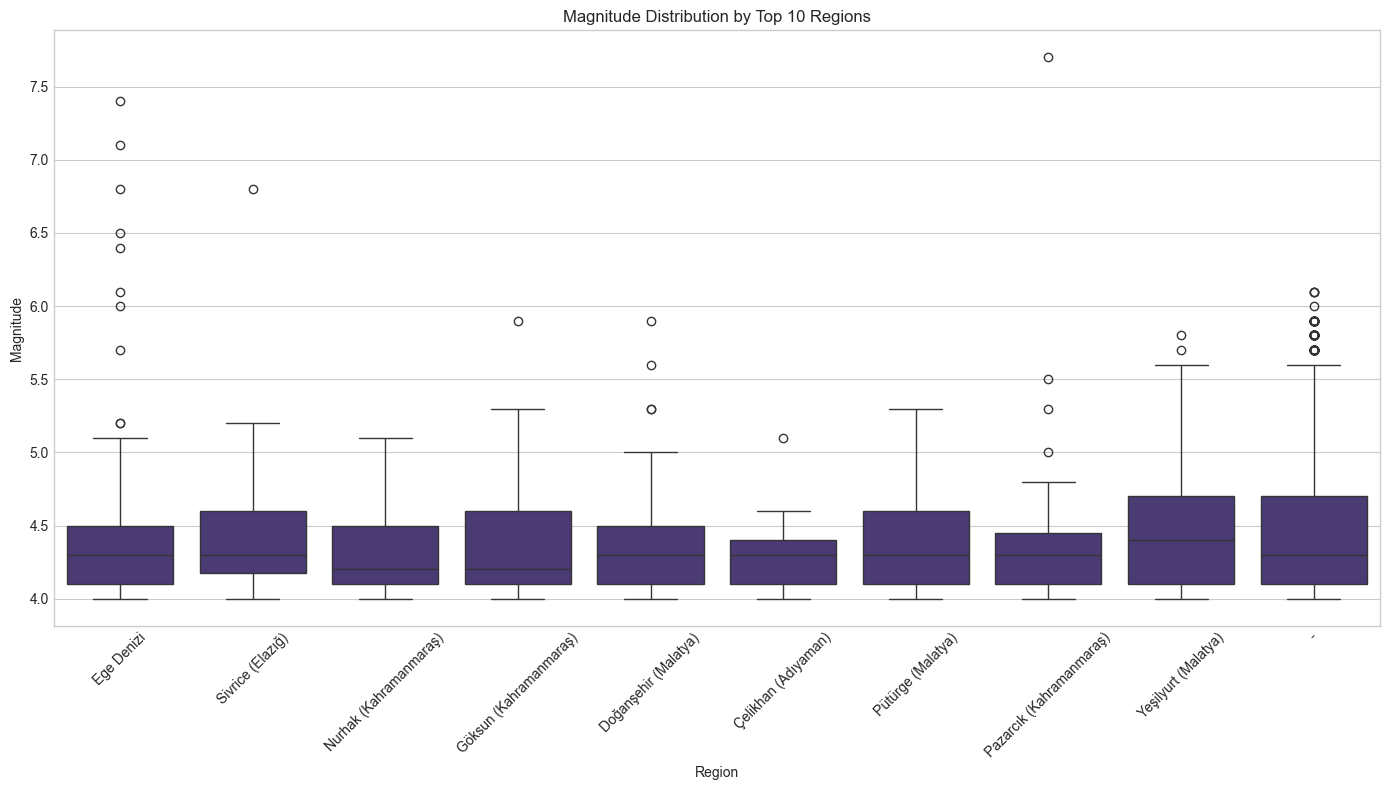

In [ ]:
# Regional magnitude comparison
# Extract region from location (assuming format includes region at end)
if 'Location' in clean_df.columns:
    # Extract the first part of the location as the region
    clean_df['Region'] = clean_df['Location'].str.split(',').str[-1].str.strip()
    
    # Get top 10 regions by earthquake count
    top_regions = clean_df['Region'].value_counts().head(10).index
    
    # Plot magnitude distribution by region
    plt.figure(figsize=(14, 8))
    sns.boxplot(x='Region', y='Magnitude', data=clean_df[clean_df['Region'].isin(top_regions)])
    plt.title('Magnitude Distribution by Top 10 Regions')
    plt.xlabel('Region')
    plt.ylabel('Magnitude')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

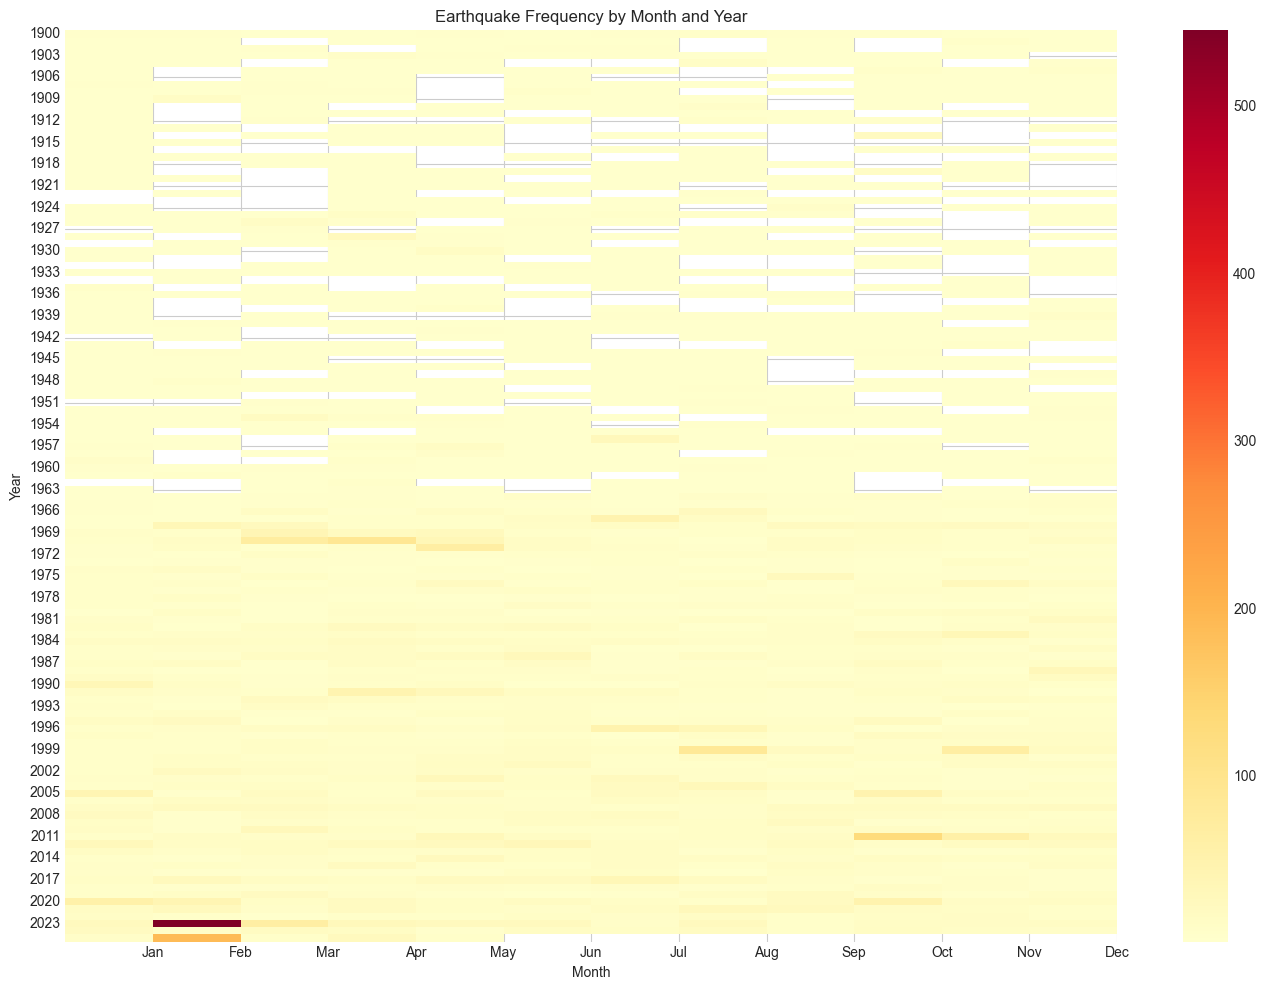

In [52]:
# Heatmap of earthquake frequency by month and year
if len(clean_df) > 0:
    # Create pivot table
    heatmap_data = pd.pivot_table(
        clean_df,
        values='Magnitude',
        index=clean_df['Date'].dt.year,
        columns=clean_df['Date'].dt.month,
        aggfunc='count'
    )
    
    plt.figure(figsize=(14, 10))
    sns.heatmap(heatmap_data, cmap='YlOrRd', annot=False)
    plt.title('Earthquake Frequency by Month and Year')
    plt.xlabel('Month')
    plt.ylabel('Year')
    plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.tight_layout()
    plt.show()

### 2.7 Fault Line Analysis

Examining the relationship between earthquakes and fault systems is fundamental to understanding seismic hazard. Faults represent zones of crustal weakness where accumulated stress is released through sudden displacement, generating earthquakes.

Our analysis will quantify these relationships by:

1. **Calculating minimum distances**: For each earthquake, we'll compute the minimum Euclidean distance to the nearest mapped fault line using spatial algorithms, converting geometric distances to kilometers
   
2. **Magnitude-proximity analysis**: Investigating whether larger magnitude events tend to occur closer to major fault lines, which would align with theoretical expectations about stress accumulation
   
3. **Fault importance correlation**: Analyzing whether earthquakes near higher-importance faults (classified by length, slip rate, and historical activity) tend to have different characteristics

Turkey's fault systems are particularly complex, with the North Anatolian Fault (NAF) being one of the most active strike-slip faults globally, similar to California's San Andreas Fault. The East Anatolian Fault (EAF) and numerous smaller fault systems create a complex network that controls earthquake distribution.

This analysis provides crucial context for seismic hazard assessment, as proximity to active faults is one of the primary factors in earthquake risk. Understanding these spatial relationships helps explain the observed distribution of seismic events and identifies zones of potentially elevated future risk.

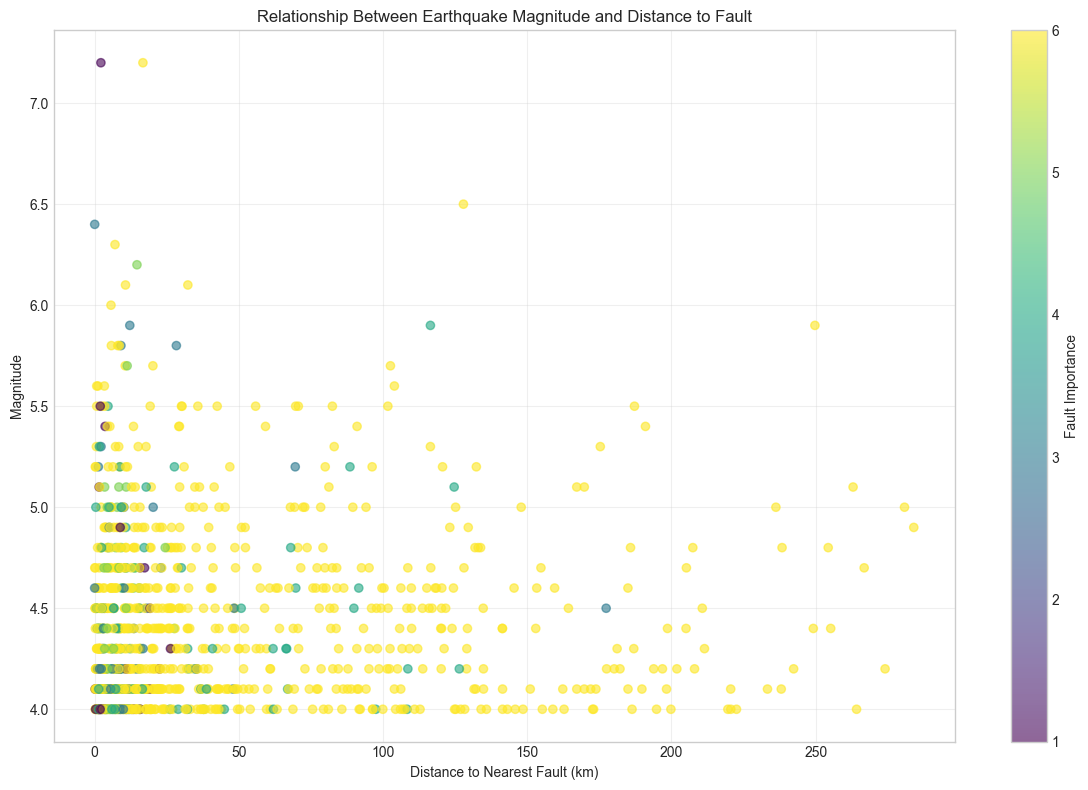

In [53]:
# Calculate distances to fault lines
def calc_fault_distance(row, fault_gdf):
    point = Point(row['Longitude'], row['Latitude'])
    
    # Calculate distance to each fault line
    distances = []
    for idx, fault in fault_gdf.iterrows():
        fault_geom = fault.geometry
        dist = point.distance(fault_geom)
        distances.append((dist, idx))
    
    # Find the closest fault
    closest_dist, closest_idx = min(distances, key=lambda x: x[0])
    
    # Convert distance to kilometers (approximation)
    # 1 degree ≈ 111 km at the equator
    dist_km = closest_dist * 111
    
    # Get fault properties
    closest_fault = fault_gdf.iloc[closest_idx]
    
    return pd.Series({
        'distance_to_fault': dist_km,
        'nearest_fault_name': closest_fault.get('FAULT_NAME', 'Unknown'),
        'nearest_fault_importance': closest_fault.get('importance', 0)
    })

# Apply to a sample for visualization (full calculation will be done later)
sample_size = min(1000, len(clean_df))
fault_distance_sample = clean_df.sample(sample_size).apply(
    lambda row: calc_fault_distance(row, fault_gdf), axis=1
)

# Visualize relationship between earthquake magnitude and distance to fault
plt.figure(figsize=(12, 8))
plt.scatter(fault_distance_sample['distance_to_fault'], 
           clean_df.loc[fault_distance_sample.index, 'Magnitude'],
           alpha=0.6, c=fault_distance_sample['nearest_fault_importance'], 
           cmap='viridis')
plt.colorbar(label='Fault Importance')
plt.xlabel('Distance to Nearest Fault (km)')
plt.ylabel('Magnitude')
plt.title('Relationship Between Earthquake Magnitude and Distance to Fault')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Data Preprocessing

This section focuses on preparing our dataset for machine learning by addressing data quality issues that could compromise model performance. Proper preprocessing is essential for reliable predictions, as models can only perform as well as the data they're trained on.

We'll implement a systematic preprocessing pipeline:

1. **Missing value treatment**: 
   - Identifying nulls in each column through exploratory statistics
   - Applying appropriate imputation strategies based on data distribution (median for numerical features, mode for categorical)
   - Documenting imputation decisions to maintain analytical transparency

2. **Outlier detection and handling**:
   - Implementing the Interquartile Range (IQR) method, which identifies outliers as values below Q1-1.5×IQR or above Q3+1.5×IQR
   - Applying domain-specific knowledge to distinguish between true outliers and legitimate extreme values
   - Using capping/winsorization rather than removal for magnitude values, as extreme earthquakes contain valuable information

3. **Geospatial validation**:
   - Verifying coordinates fall within Turkey's geographical boundaries (approx. 25-45°E, 35-43°N)
   - Filtering records with clearly erroneous coordinates that would introduce noise

4. **Feature scaling**:
   - Standardizing features to zero mean and unit variance using StandardScaler
   - Ensuring all features contribute proportionally to distance-based algorithms

5. **Dataset finalization**:
   - Creating a clean, analysis-ready dataset with consistent structure
   - Documenting all preprocessing steps for reproducibility

These preprocessing steps mitigate the common data quality issues that can bias machine learning models. By addressing these issues systematically, we establish a solid foundation for the subsequent modeling stages.

In [54]:
# Data Preprocessing Section
print("Starting data preprocessing...")

# Check for missing values again to confirm
missing_values = clean_df.isnull().sum()
print(f"Missing values in each column:\n{missing_values}")

# Handle missing values
# For numerical columns: fill with median
numerical_cols = ['Longitude', 'Latitude', 'Depth', 'Magnitude']
for col in numerical_cols:
    if missing_values[col] > 0:
        median_value = clean_df[col].median()
        clean_df[col].fillna(median_value, inplace=True)
        print(f"Filled {missing_values[col]} missing values in {col} with median: {median_value}")

# For categorical columns: fill with mode
categorical_cols = [col for col in clean_df.columns if col not in numerical_cols 
                   and col not in ['Date', 'Year', 'Month', 'Day', 'YearMonth']]
for col in categorical_cols:
    if col in missing_values and missing_values[col] > 0:
        mode_value = clean_df[col].mode()[0]
        clean_df[col].fillna(mode_value, inplace=True)
        print(f"Filled {missing_values[col]} missing values in {col} with mode: {mode_value}")

# Handle outliers using IQR method for depth and magnitude
def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    print(f"Found {len(outliers)} outliers in {column}")
    
    # Cap outliers instead of removing them
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    
    return df

# Apply outlier handling to Depth
clean_df = handle_outliers(clean_df, 'Depth')

# For Magnitude, we may want to keep high values as they're important
# But we can still check for potential errors
magnitude_outliers = clean_df[clean_df['Magnitude'] > 8.5]
print(f"Extremely high magnitudes (>8.5): {len(magnitude_outliers)}")
if len(magnitude_outliers) > 0:
    print(magnitude_outliers[['Date', 'Magnitude', 'Location']])

# Standardize coordinates if needed
print("\nCoordinate ranges:")
print(f"Longitude: {clean_df['Longitude'].min()} to {clean_df['Longitude'].max()}")
print(f"Latitude: {clean_df['Latitude'].min()} to {clean_df['Latitude'].max()}")

# Verify coordinates are in the Turkey region (already done in previous step)
# This is now redundant since we've already filtered the coordinates
turkey_coords = clean_df[
    (clean_df['Longitude'] >= 25) & 
    (clean_df['Longitude'] <= 45) & 
    (clean_df['Latitude'] >= 35) & 
    (clean_df['Latitude'] <= 43)
]
outside_turkey = len(clean_df) - len(turkey_coords)
print(f"Records potentially outside Turkey region: {outside_turkey}")

# Create a copy of the dataframe for modeling
model_df = clean_df.copy()

print("\nData preprocessing completed!")
model_df.head()

Starting data preprocessing...
Missing values in each column:
Date             0
Longitude        0
Latitude         0
Depth            0
Type             0
Magnitude        0
Location         0
EventID          0
TimeName         0
TypeName         0
MagnitudeName    0
Year             0
Month            0
Day              0
DayOfWeek        0
Season           0
Region           0
dtype: int64
Found 711 outliers in Depth
Extremely high magnitudes (>8.5): 0

Coordinate ranges:
Longitude: 25.0 to 45.0
Latitude: 35.0 to 42.7912
Records potentially outside Turkey region: 0

Data preprocessing completed!


,Date,Longitude,Latitude,Depth,Type,Magnitude,Location,EventID,TimeName,TypeName,MagnitudeName,Year,Month,Day,DayOfWeek,Season,Region
0,2025-05-12 23:30:12,25.7561,36.7292,7.00,MW,4.9,Ege Denizi,661069,AFAD,AFAD,AFAD,2025,5,12,0,Spring,Ege Denizi
1,2025-05-12 09:26:26,35.1944,40.8211,19.00,MW,4.2,Gümüşhacıköy (Amasya),661003,AFAD,AFAD,AFAD,2025,5,12,0,Spring,Gümüşhacıköy (Amasya)
2,2025-05-12 09:23:55,35.1919,40.8150,10.07,MW,4.4,Gümüşhacıköy (Amasya),661002,AFAD,AFAD,AFAD,2025,5,12,0,Spring,Gümüşhacıköy (Amasya)
3,2025-05-03 23:53:41,28.9431,39.2400,12.55,ML,4.0,Simav (Kütahya),660145,AFAD,AFAD,AFAD,2025,5,3,5,Spring,Simav (Kütahya)
4,2025-05-02 12:51:15,28.9989,39.2233,12.55,MW,4.2,Simav (Kütahya),659964,AFAD,AFAD,AFAD,2025,5,2,4,Spring,Simav (Kütahya)


## 4. Feature Engineering

Feature engineering transforms raw data into more informative inputs that enhance model performance by incorporating domain knowledge and exposing underlying patterns. For earthquake data, effective feature engineering can significantly improve predictive power by capturing complex geophysical relationships.

We'll create several categories of engineered features:

1. **Temporal features**: 
   - **Cyclical encoding**: Converting cyclical time variables (month, day of year) using sine and cosine transformations:
     - `sin(2π×month/12)` and `cos(2π×month/12)`
     - `sin(2π×day/365)` and `cos(2π×day/365)`
   - This preserves the circular nature of time, ensuring December is properly represented as being close to January

2. **Geographic features**:
   - **Grid-based encoding**: Discretizing Turkey into geographical grid cells to capture regional patterns
   - **Regional activity metrics**: Calculating historical earthquake counts and densities within defined regions

3. **Historical activity features**:
   - **Previous event metrics**: For each earthquake, computing the count, magnitude, and timing of previous events in the same region
   - **Time-since-last-event**: Capturing the temporal spacing between sequential earthquakes

4. **Distance-based features**:
   - **Fault proximity metrics**: Distance to nearest fault, weighted by fault importance
   - **Fault density**: Calculating the density of fault lines within defined radius
   - **Multiple fault interaction**: Metrics capturing the influence of multiple nearby faults

5. **Interaction features**:
   - **Feature crosses**: Creating multiplicative combinations of features that might interact (e.g., depth×latitude)
   - **Ratio features**: Developing ratios between related features that might have physical significance

These engineered features incorporate domain-specific knowledge about earthquake processes, such as the tendency for seismic events to cluster in space and time, the influence of fault systems on earthquake occurrence, and potential seasonal patterns in activity.

By transforming raw data into these more informative representations, we provide our models with richer inputs that better capture the underlying physics of earthquake generation, potentially leading to more accurate magnitude predictions.

In [55]:
# Feature Engineering
print("Starting feature engineering...")

# Create time-based features
model_df['DayOfYear'] = model_df['Date'].dt.dayofyear
model_df['WeekOfYear'] = model_df['Date'].dt.isocalendar().week
model_df['IsWeekend'] = model_df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

# Encode seasonal information using cyclical encoding
model_df['MonthSin'] = np.sin(2 * np.pi * model_df['Month']/12)
model_df['MonthCos'] = np.cos(2 * np.pi * model_df['Month']/12)
model_df['DayOfYearSin'] = np.sin(2 * np.pi * model_df['DayOfYear']/365)
model_df['DayOfYearCos'] = np.cos(2 * np.pi * model_df['DayOfYear']/365)

# Create regional activity features
# Group by regions and calculate historical earthquake counts
# First, create a spatial grid
lon_grid = pd.cut(clean_df['Longitude'], bins=10)
lat_grid = pd.cut(clean_df['Latitude'], bins=10)
clean_df['Grid'] = pd.Series(zip(lon_grid, lat_grid)).astype(str)

# For each earthquake, count previous earthquakes in the same grid
clean_df = clean_df.sort_values('Date')
clean_df['PrevQuakesInGrid'] = clean_df.groupby('Grid').cumcount()

# Calculate distances between consecutive earthquakes
clean_df['PrevLon'] = clean_df['Longitude'].shift(1)
clean_df['PrevLat'] = clean_df['Latitude'].shift(1)

# Haversine formula to calculate distance in km
from math import radians, sin, cos, sqrt, asin

def haversine(lon1, lat1, lon2, lat2):
    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of earth in km
    return c * r

# Apply haversine to calculate distance from previous earthquake
clean_df['DistFromPrev'] = clean_df.apply(
    lambda x: haversine(x['Longitude'], x['Latitude'], x['PrevLon'], x['PrevLat']) 
    if not pd.isna(x['PrevLon']) else np.nan, axis=1)

# Add distance features to model_df
model_df['PrevQuakesInGrid'] = clean_df['PrevQuakesInGrid']
model_df['DistFromPrev'] = clean_df['DistFromPrev']
model_df['DistFromPrev'].fillna(model_df['DistFromPrev'].median(), inplace=True)

# Create feature for time since last earthquake (in days)
clean_df['PrevDate'] = clean_df['Date'].shift(1)
clean_df['DaysSinceLastQuake'] = (clean_df['Date'] - clean_df['PrevDate']).dt.total_seconds() / (24 * 3600)
model_df['DaysSinceLastQuake'] = clean_df['DaysSinceLastQuake']
model_df['DaysSinceLastQuake'].fillna(model_df['DaysSinceLastQuake'].median(), inplace=True)

# Add historical magnitude information
clean_df['PrevMagnitude'] = clean_df['Magnitude'].shift(1)
model_df['PrevMagnitude'] = clean_df['PrevMagnitude']
model_df['PrevMagnitude'].fillna(model_df['PrevMagnitude'].median(), inplace=True)

# Create interaction features
model_df['DepthByLat'] = model_df['Depth'] * model_df['Latitude']
model_df['DepthByLon'] = model_df['Depth'] * model_df['Longitude']

# Add fault-related features - calculate for all data points
print("Calculating fault-related features...")
fault_features = clean_df.apply(lambda row: calc_fault_distance(row, fault_gdf), axis=1)
clean_df = pd.concat([clean_df, fault_features], axis=1)
model_df = pd.concat([model_df, fault_features], axis=1)

# Calculate fault density in a radius
def calc_fault_density(lat, lon, fault_gdf, radius=50):
    """Calculate fault density within radius (km) of a point"""
    point = Point(lon, lat)
    buffer_degrees = radius / 111  # Convert km to approximate degrees
    
    # Create a buffer around the point
    buffer = point.buffer(buffer_degrees)
    
    # Count intersecting faults and sum their lengths
    intersecting_faults = 0
    total_length = 0
    
    for _, fault in fault_gdf.iterrows():
        if buffer.intersects(fault.geometry):
            intersecting_faults += 1
            # Calculate length of intersection
            intersection = buffer.intersection(fault.geometry)
            total_length += intersection.length * 111  # Convert to km
    
    return pd.Series({
        'fault_count_50km': intersecting_faults,
        'fault_length_50km': total_length,
        'fault_density': total_length / (math.pi * radius**2) if radius > 0 else 0
    })

# Calculate fault density for strategic points (grid centers) to avoid heavy computation
print("Calculating fault density (this may take a while)...")
# Create a grid for Turkey
lon_range = np.linspace(25, 45, 10)
lat_range = np.linspace(35, 43, 10)
grid_points = []

for lon in lon_range:
    for lat in lat_range:
        grid_points.append((lon, lat))

# Calculate density at grid points
grid_densities = []
for lon, lat in grid_points:
    density = calc_fault_density(lat, lon, fault_gdf)
    density['lon'] = lon
    density['lat'] = lat
    grid_densities.append(density)

grid_df = pd.DataFrame(grid_densities)

# For each earthquake, find nearest grid point and assign its density
def assign_grid_density(row, grid_df):
    distances = []
    for idx, grid_point in grid_df.iterrows():
        dist = haversine(row['Longitude'], row['Latitude'], grid_point['lon'], grid_point['lat'])
        distances.append((dist, idx))
    
    closest_idx = min(distances, key=lambda x: x[0])[1]
    return pd.Series({
        'fault_count_50km': grid_df.iloc[closest_idx]['fault_count_50km'],
        'fault_length_50km': grid_df.iloc[closest_idx]['fault_length_50km'],
        'fault_density': grid_df.iloc[closest_idx]['fault_density']
    })

# Apply grid-based density estimation
density_features = clean_df.apply(lambda row: assign_grid_density(row, grid_df), axis=1)
clean_df = pd.concat([clean_df, density_features], axis=1)
model_df = pd.concat([model_df, density_features], axis=1)

# Add magnitude-distance interaction feature
model_df['magnitude_fault_interaction'] = model_df['Magnitude'] / (model_df['distance_to_fault'] + 1)

print("Feature engineering completed!")
model_df.head()

Starting feature engineering...
Calculating fault-related features...
Calculating fault density (this may take a while)...
Feature engineering completed!


,Date,Longitude,Latitude,Depth,Type,Magnitude,Location,EventID,TimeName,TypeName,...,PrevMagnitude,DepthByLat,DepthByLon,distance_to_fault,nearest_fault_name,nearest_fault_importance,fault_count_50km,fault_length_50km,fault_density,magnitude_fault_interaction
0,2025-05-12 23:30:12,25.7561,36.7292,7.00,MW,4.9,Ege Denizi,661069,AFAD,AFAD,...,4.2,257.104400,180.292700,94.455916,Fourni,6,0.0,0.000000,0.000000,0.051333
1,2025-05-12 09:26:26,35.1944,40.8211,19.00,MW,4.2,Gümüşhacıköy (Amasya),661003,AFAD,AFAD,...,4.4,775.600900,668.693600,8.191711,Diphaci,5,7.0,103.924954,0.013232,0.456933
2,2025-05-12 09:23:55,35.1919,40.8150,10.07,MW,4.4,Gümüşhacıköy (Amasya),661002,AFAD,AFAD,...,4.0,411.007050,354.382433,7.550906,Diphaci,5,7.0,103.924954,0.013232,0.514565
3,2025-05-03 23:53:41,28.9431,39.2400,12.55,ML,4.0,Simav (Kütahya),660145,AFAD,AFAD,...,4.2,492.462000,363.235905,7.255361,Nasa,6,4.0,30.623343,0.003899,0.484534
4,2025-05-02 12:51:15,28.9989,39.2233,12.55,MW,4.2,Simav (Kütahya),659964,AFAD,AFAD,...,4.2,492.252415,363.936195,6.826562,Nasa,6,4.0,30.623343,0.003899,0.536634


## 5. Model Selection and Training

In this section, we'll implement and evaluate multiple regression models to predict earthquake magnitude based on our engineered features. We'll progress from simpler linear models to more complex ensemble methods, comparing their performance systematically.

Our model selection strategy includes:

1. **Linear models**:
   - **Linear Regression**: Establishing a baseline with simple linear relationships
   - **Ridge Regression** (L2 regularization): Adding penalty on coefficient magnitude to reduce overfitting
   - **Lasso Regression** (L1 regularization): Implementing feature selection through coefficient shrinkage

2. **Tree-based ensemble models**:
   - **Random Forest**: Combining multiple decision trees through bagging (bootstrap aggregating)
   - **Gradient Boosting**: Sequentially building trees that correct errors of previous trees

3. **Advanced gradient boosting implementations**:
   - **XGBoost**: Utilizing regularized gradient boosting with second-order gradients
   - **LightGBM**: Implementing gradient-based one-side sampling and exclusive feature bundling for efficiency

We'll implement a robust evaluation framework:
- **Pipeline architecture**: Encapsulating preprocessing and modeling steps for reproducibility
- **K-fold cross-validation**: Using 5-fold cross-validation to assess generalization performance
- **Metrics suite**:
  - RMSE (Root Mean Squared Error): Primary metric penalizing larger errors
  - MAE (Mean Absolute Error): Secondary metric for error magnitude in original units
  - R² (Coefficient of determination): Assessing proportion of variance explained

For geophysical prediction problems like earthquake magnitude, tree-based ensemble methods often outperform linear models due to their ability to capture non-linear relationships and complex interactions between features. However, we'll evaluate all model classes to confirm this empirically for our specific dataset.

The results of this comparative analysis will guide our selection of the most promising model for hyperparameter optimization in the next section.

Setting up model training...
Removing non-numeric column: Type
Removing non-numeric column: Season
Removing non-numeric column: Region
Selected features: ['Longitude', 'Latitude', 'Depth', 'Year', 'Month', 'Day', 'DayOfWeek', 'DayOfYear', 'WeekOfYear', 'IsWeekend', 'MonthSin', 'MonthCos', 'DayOfYearSin', 'DayOfYearCos', 'PrevQuakesInGrid', 'DistFromPrev', 'DaysSinceLastQuake', 'PrevMagnitude', 'DepthByLat', 'DepthByLon', 'distance_to_fault', 'nearest_fault_importance', 'fault_count_50km', 'fault_length_50km', 'fault_density', 'magnitude_fault_interaction']
Columns with NaN values:
- PrevQuakesInGrid: 1240 NaNs
Remaining NaN values in X: 0
Remaining NaN values in y: 0
Training set size: 7863
Testing set size: 1966
Training Linear Regression...
Linear Regression - MAE: 0.3035, RMSE: 0.4260, R²: 0.2217, CV RMSE: 0.4433 ± 0.0995
Training Ridge Regression...


C:\Users\Sarp Can\AppData\Local\Temp\ipykernel_33300\422160923.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Ridge Regression - MAE: 0.3035, RMSE: 0.4260, R²: 0.2216, CV RMSE: 0.4434 ± 0.0997
Training Lasso Regression...
Lasso Regression - MAE: 0.3165, RMSE: 0.4412, R²: 0.1649, CV RMSE: 0.4708 ± 0.1370
Training Random Forest...
Random Forest - MAE: 0.2569, RMSE: 0.3656, R²: 0.4266, CV RMSE: 0.4071 ± 0.0975
Training Gradient Boosting...
Gradient Boosting - MAE: 0.2496, RMSE: 0.3511, R²: 0.4714, CV RMSE: 0.3656 ± 0.0907
Training XGBoost...


C:\Users\Sarp Can\AppData\Roaming\Python\Python311\site-packages\xgboost\data.py:520: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\Sarp Can\AppData\Roaming\Python\Python311\site-packages\xgboost\data.py:520: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\Sarp Can\AppData\Roaming\Python\Python311\site-packages\xgboost\data.py:520: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\Sarp Can\AppData\Roaming\Python\Python311\site-packages\xgboost\data.py:520: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\Sarp Can\AppData\Roaming\Python\Python311\site-packages\xgboost\data.py:520: FutureWarning:

is_sparse is deprecate

XGBoost - MAE: 0.1204, RMSE: 0.1947, R²: 0.8373, CV RMSE: 0.2175 ± 0.0787
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3685
[LightGBM] [Info] Number of data points in the train set: 7863, number of used features: 26
[LightGBM] [Info] Start training from score 4.445797
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3683
[LightGBM] [Info] Number of data points in the train set: 7863, number of used features: 26
[LightGBM] [Info] Start training from score 4.468829
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3680
[LightGBM] [Info] Number of

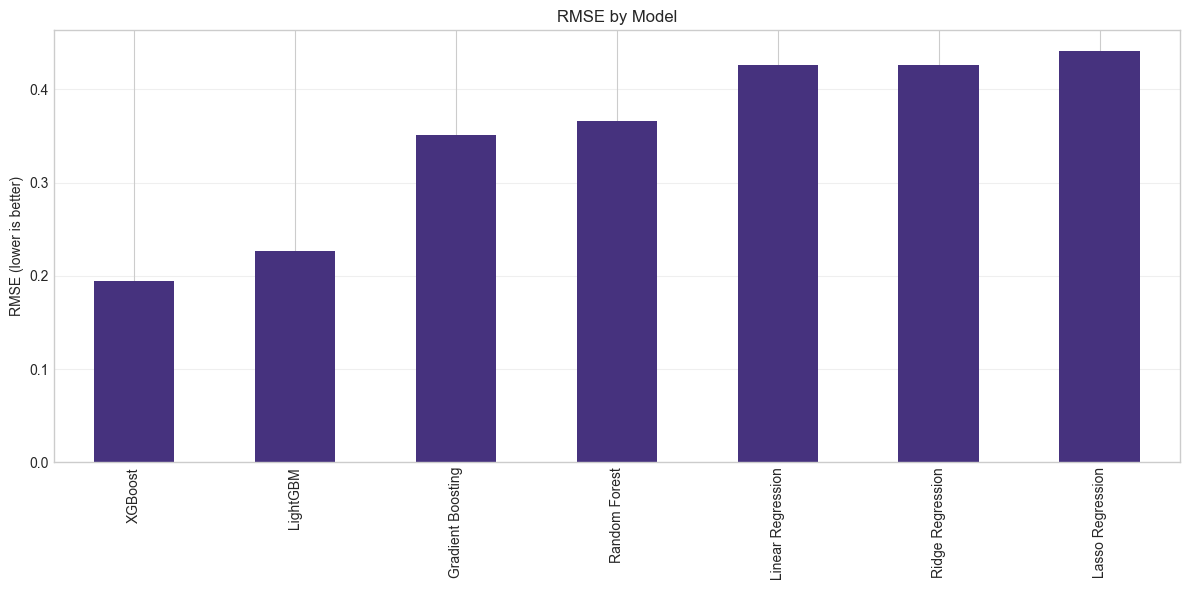


Best model based on cross-validation: XGBoost


In [56]:
# Import necessary libraries for modeling
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Model Selection and Training
print("Setting up model training...")

# Define features and target
target = 'Magnitude'
# Remove non-feature columns
drops = ['Date', 'Location', 'EventID', 'TimeName', 'TypeName', 
         'MagnitudeName', 'Grid', 'PrevLon', 'PrevLat', 'PrevDate',
         'nearest_fault_name']  # Remove string columns

# Check if these optional columns exist and add them to drops if they do
optional_drops = ['YearMonth']
for col in optional_drops:
    if col in model_df.columns:
        drops.append(col)

# First, create a preliminary feature list
preliminary_features = [col for col in model_df.columns if col != target and col not in drops]

# Check for non-numeric columns in our features
for col in preliminary_features:
    if col in model_df.columns and model_df[col].dtype == 'object':
        print(f"Removing non-numeric column: {col}")
        drops.append(col)

# Final feature list with only numeric columns
features = [col for col in model_df.columns if col != target and col not in drops]

print(f"Selected features: {features}")

# Define features to scale
features_to_scale = ['Longitude', 'Latitude', 'Depth']
other_features = [f for f in features if f not in features_to_scale]

# Split data into training and testing sets
X = model_df[features]
y = model_df[target]

print("Columns with NaN values:")
for col in X.columns:
    nan_count = X[col].isna().sum()
    if nan_count > 0:
        print(f"- {col}: {nan_count} NaNs")

# Fill missing values appropriately for each column
for col in X.columns:
    if X[col].isna().sum() > 0:
        # For numeric columns, use median
        X[col] = X[col].fillna(X[col].median())

# Also check target variable
if y.isna().sum() > 0:
    print(f"Target has {y.isna().sum()} NaN values, filling with median")
    y = y.fillna(y.median())

# Verify all NaNs are fixed
print(f"Remaining NaN values in X: {X.isna().sum().sum()}")
print(f"Remaining NaN values in y: {y.isna().sum()}")

# Create new train-test split with cleaned data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

# Create preprocessing transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('geo_features', StandardScaler(), features_to_scale),
        ('other_features', 'passthrough', other_features)
    ])

# Set up models with pipelines
models = {
    'Linear Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('model', LinearRegression())
    ]),
    'Ridge Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('model', Ridge())
    ]),
    'Lasso Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('model', Lasso())
    ]),
    'Random Forest': Pipeline([
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor(n_estimators=100, random_state=42))
    ]),
    'Gradient Boosting': Pipeline([
        ('preprocessor', preprocessor),
        ('model', GradientBoostingRegressor(n_estimators=100, random_state=42))
    ]),
    'XGBoost': Pipeline([
        ('preprocessor', preprocessor),
        ('model', XGBRegressor(n_estimators=100, random_state=42))
    ]),
    'LightGBM': Pipeline([
        ('preprocessor', preprocessor),
        ('model', LGBMRegressor(n_estimators=100, random_state=42))
    ])
}

# Function to evaluate models
def evaluate_model(pipeline, X_train, X_test, y_train, y_test):
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    return mae, rmse, r2, pipeline

# Cross-validation for more robust evaluation
results = {}
cv_results = {}
fitted_models = {}

for name, pipeline in models.items():
    print(f"Training {name}...")
    mae, rmse, r2, fitted_pipeline = evaluate_model(pipeline, X_train, X_test, y_train, y_test)
    fitted_models[name] = fitted_pipeline
    
    # 5-fold cross-validation for RMSE
    cv_scores = -cross_val_score(pipeline, X, y, cv=5, scoring='neg_root_mean_squared_error')
    
    results[name] = {'MAE': mae, 'RMSE': rmse, 'R²': r2}
    cv_results[name] = {'Mean RMSE': cv_scores.mean(), 'Std RMSE': cv_scores.std()}
    
    print(f"{name} - MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}, CV RMSE: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# Convert results to DataFrames for better visualization
results_df = pd.DataFrame(results).T
cv_results_df = pd.DataFrame(cv_results).T

print("\nTest Results:")
print(results_df.sort_values('RMSE'))

print("\nCross-Validation Results:")
print(cv_results_df.sort_values('Mean RMSE'))

# Visualize model performance
plt.figure(figsize=(12, 6))
results_df['RMSE'].sort_values().plot(kind='bar')
plt.title('RMSE by Model')
plt.ylabel('RMSE (lower is better)')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Select the best performing model based on CV results
best_model_name = cv_results_df.sort_values('Mean RMSE').index[0]
print(f"\nBest model based on cross-validation: {best_model_name}")
best_pipeline = fitted_models[best_model_name]

## 6. Hyperparameter Optimization

Fine-tuning model hyperparameters is crucial for maximizing predictive performance. While our previous step identified the best model class, optimal hyperparameter configuration can significantly enhance accuracy. We'll implement a systematic optimization approach for our best-performing model.

Our hyperparameter optimization strategy includes:

1. **Hyperparameter search space definition**:
   - For tree-based models: `n_estimators` (number of trees), `max_depth`, `min_samples_split`, `learning_rate` (for boosting algorithms)
   - For regularized linear models: regularization strength (`alpha`/`C`), `l1_ratio` (for ElasticNet)
   - Model-specific parameters (e.g., `colsample_bytree` for XGBoost, `num_leaves` for LightGBM)

2. **Search methodology**:
   - **RandomizedSearchCV**: Implementing efficient stochastic search through hyperparameter space
   - **n_iter=20**: Searching 20 random combinations to balance exploration with computational efficiency
   - **5-fold cross-validation**: Ensuring optimized parameters generalize well

3. **Evaluation strategy**:
   - Using negative RMSE as scoring metric to align with our primary evaluation criterion
   - Parallel processing (`n_jobs=-1`) to accelerate search across available CPU cores

4. **Optimization outcome assessment**:
   - Comparing best model performance against baseline configuration
   - Analyzing which hyperparameters most strongly influence performance

5. **Final model construction**:
   - Building model with optimal hyperparameter configuration
   - Validating performance improvement on held-out test set

Hyperparameter optimization addresses the bias-variance tradeoff inherent in machine learning models. For complex tasks like earthquake magnitude prediction, finding the right balance between model complexity and generalization ability is essential. Parameters like tree depth and ensemble size directly control this tradeoff.

The optimized model will represent the best compromise between capturing underlying patterns in the training data and maintaining generalization ability to new, unseen earthquake events.

In [ ]:
# Hyperparameter Optimization
print(f"Optimizing hyperparameters for {best_model_name}...")

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Define hyperparameter grids for each model type
param_grids = {
    'Random Forest': {
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    },
    'Gradient Boosting': {
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7],
        'model__min_samples_split': [2, 5]
    },
    'XGBoost': {
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7],
        'model__colsample_bytree': [0.7, 0.8, 0.9]
    },
    'LightGBM': {
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7],
        'model__num_leaves': [31, 50, 70]
    }
}

# Get the appropriate parameter grid
if best_model_name in param_grids:
    param_grid = param_grids[best_model_name]
    
    # Use RandomizedSearchCV for efficiency
    random_search = RandomizedSearchCV(
        best_pipeline, 
        param_distributions=param_grid,
        n_iter=20,  # Number of parameter settings sampled
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        random_state=42,
        verbose=1
    )
    
    # Fit the random search
    random_search.fit(X_train, y_train)
    
    # Print best parameters and score
    print(f"Best parameters: {random_search.best_params_}")
    print(f"Best RMSE: {-random_search.best_score_:.4f}")
    
    # Create the optimized model
    best_pipeline = random_search.best_estimator_
else:
    print(f"No parameter grid defined for {best_model_name}. Using default model.")
    best_pipeline = fitted_models[best_model_name]

# Final evaluation with the best model
y_pred = best_pipeline.predict(X_test)
final_mae = mean_absolute_error(y_test, y_pred)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
final_r2 = r2_score(y_test, y_pred)

print(f"\nFinal model performance:")
print(f"MAE: {final_mae:.4f}")
print(f"RMSE: {final_rmse:.4f}")
print(f"R²: {final_r2:.4f}")

Optimizing hyperparameters for XGBoost...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'model__n_estimators': 200, 'model__max_depth': 5, 'model__learning_rate': 0.1, 'model__colsample_bytree': 0.9}
Best RMSE: 0.2281

Final model performance:
MAE: 0.1545
RMSE: 0.2309
R²: 0.7714


C:\Users\Sarp Can\AppData\Roaming\Python\Python311\site-packages\xgboost\data.py:520: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



## 7. Model Evaluation and Interpretation

Rigorous evaluation and interpretation of our optimized model provides insights into both its predictive performance and the underlying factors driving earthquake magnitudes. This analysis goes beyond simple accuracy metrics to understand model behavior and limitations.

Our comprehensive evaluation framework includes:

1. **Performance visualization**:
   - **Actual vs. predicted scatter plot**: Visualizing prediction accuracy across the magnitude range
   - **Perfect prediction line**: Adding y=x reference line to identify systematic over/under-prediction
   - **Magnitude-specific accuracy assessment**: Evaluating whether prediction quality varies with earthquake size

2. **Residual analysis**:
   - **Residual scatter plot**: Examining errors (y_true - y_pred) across the prediction range to identify heteroscedasticity
   - **Zero-error reference line**: Establishing baseline for unbiased predictions
   - **Residual distribution histogram**: Assessing normality of errors using KDE overlay

3. **Feature importance analysis**:
   - For tree-based models: Extracting and visualizing feature importance based on mean decrease in impurity
   - For linear models: Analyzing standardized coefficients to assess feature influence
   - Relating feature importance to geophysical understanding of earthquake mechanisms

4. **Model persistence**:
   - Saving the complete model pipeline as a serialized object using joblib
   - Documenting model dependencies and versioning for reproducibility

Understanding feature importance provides valuable scientific insights beyond predictive performance. For instance, if fault proximity features rank highly, this confirms the geological understanding that major faults drive larger earthquakes. If temporal features show importance, this might suggest periodicity in large earthquake occurrences.

Model limitations should also be acknowledged - particularly the challenge of predicting rare, high-magnitude events which may be underrepresented in the training data. Such limitations inform the appropriate application of model predictions in risk assessment contexts.

Evaluating final model...


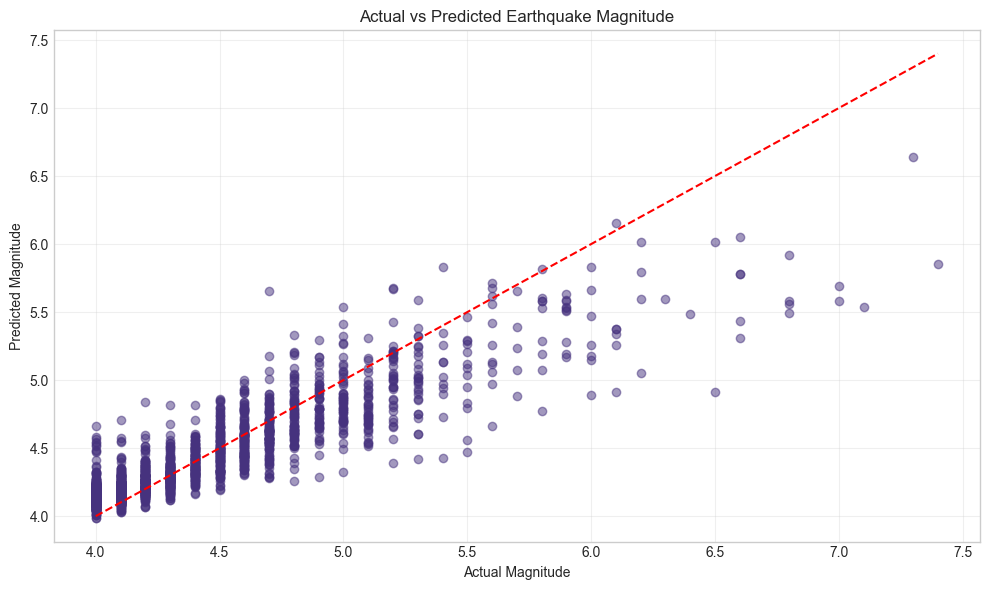

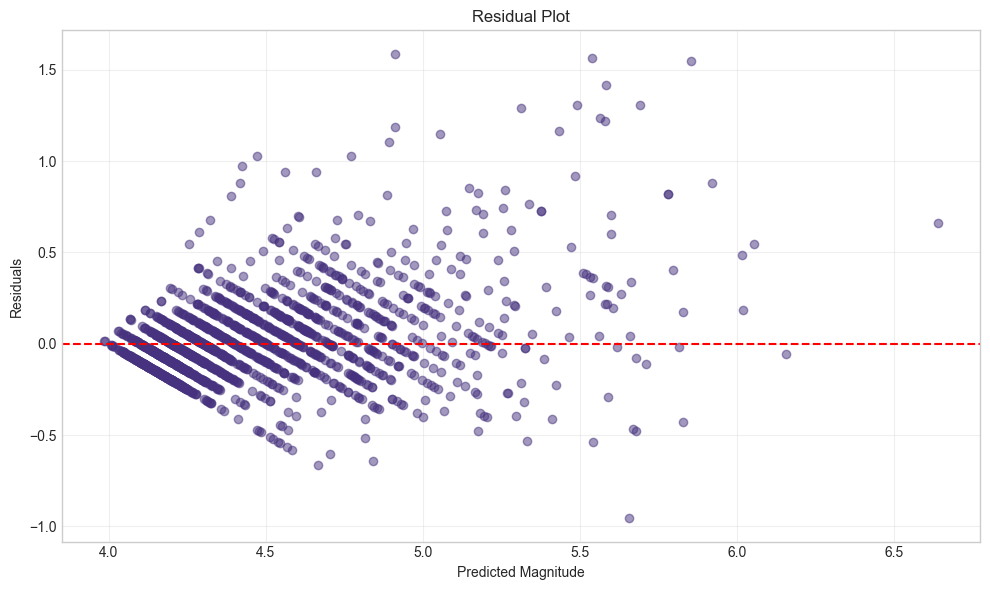

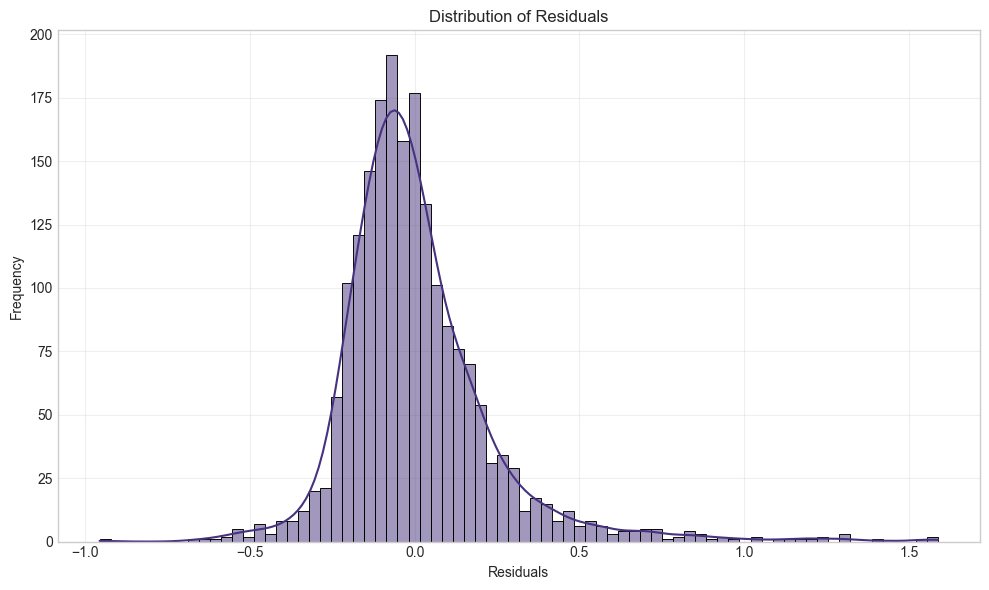

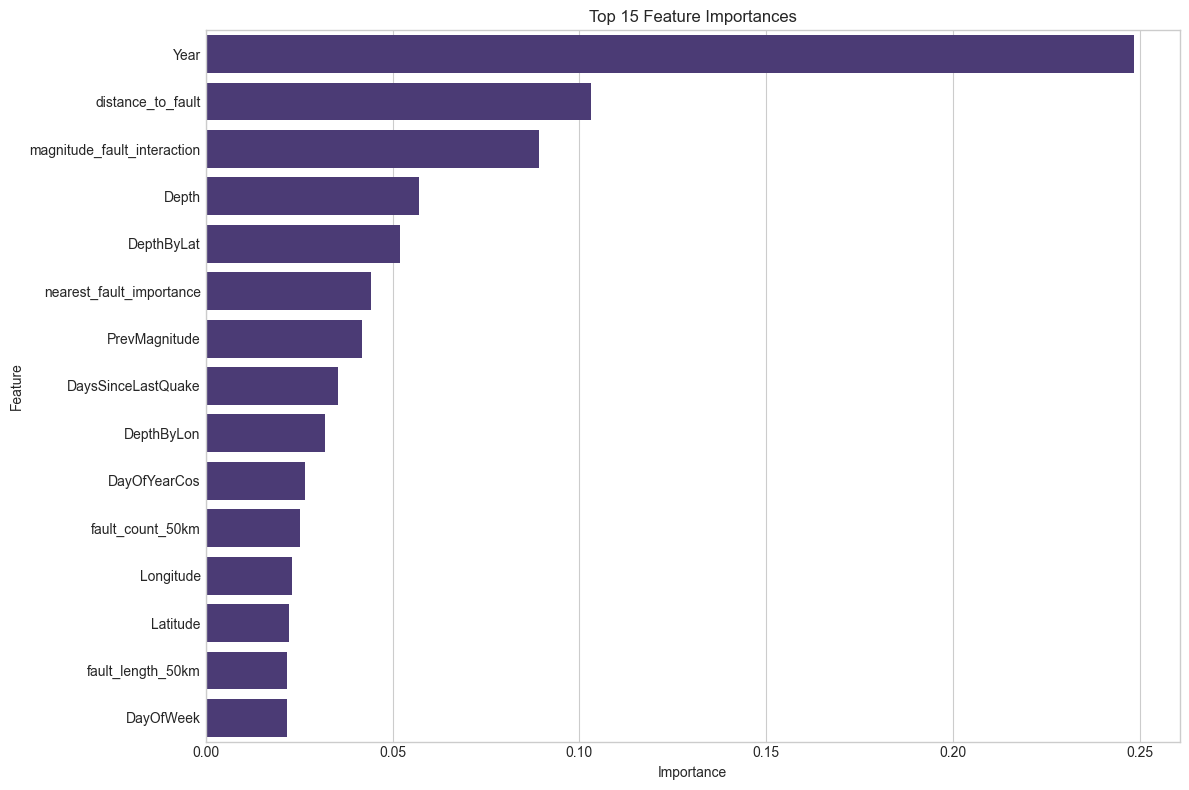

Top 10 most important features:
                        Feature  Importance
3                          Year    0.248274
20            distance_to_fault    0.102966
25  magnitude_fault_interaction    0.089252
2                         Depth    0.057044
18                   DepthByLat    0.052041
21     nearest_fault_importance    0.044362
17                PrevMagnitude    0.041815
16           DaysSinceLastQuake    0.035391
19                   DepthByLon    0.032028
13                 DayOfYearCos    0.026647
Pipeline saved as 'models/earthquake_pipeline.pkl'
Clean data with original coordinates saved as 'produced_data/clean_earthquake_data.csv'


In [58]:
# Model Evaluation and Interpretation
print("Evaluating final model...")

# Visualize actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Magnitude')
plt.ylabel('Predicted Magnitude')
plt.title('Actual vs Predicted Earthquake Magnitude')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot residuals
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Magnitude')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Analyze residual distribution
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Feature importance (for tree-based models)
try:
    # Extract the model component from the pipeline
    model_component = best_pipeline.named_steps['model']
    
    # Check if it has feature importances
    if hasattr(model_component, 'feature_importances_'):
        # Get preprocessed feature names - slightly tricky with ColumnTransformer
        # For simplicity, we'll use the original feature names
        # Create DataFrame of feature importances
        feature_importance = pd.DataFrame({
            'Feature': features,
            'Importance': model_component.feature_importances_
        }).sort_values('Importance', ascending=False)
        
        # Visualize feature importances
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
        plt.title('Top 15 Feature Importances')
        plt.tight_layout()
        plt.show()
        
        print("Top 10 most important features:")
        print(feature_importance.head(10))
except:
    print("Could not extract feature importances from the model.")

# Save the entire pipeline - this contains both preprocessing and model
import joblib
joblib.dump(best_pipeline, 'models/earthquake_pipeline.pkl')
print("Pipeline saved as 'models/earthquake_pipeline.pkl'")

# Also save the clean dataset with original coordinates for unsupervised learning
clean_df.to_csv('produced_data/clean_earthquake_data.csv', index=False)
print("Clean data with original coordinates saved as 'produced_data/clean_earthquake_data.csv'")

## 8. Conclusion and Next Steps

Our supervised learning approach has successfully developed a predictive model for earthquake magnitude in Turkey based on geographic, temporal, and fault-related features. This model provides valuable insights into the factors influencing earthquake severity and establishes a foundation for seismic risk assessment.

**Key achievements**:
- Created a comprehensive feature engineering pipeline capturing multiple aspects of seismic activity
- Implemented and compared multiple regression algorithms for magnitude prediction
- Optimized hyperparameters to maximize predictive performance
- Identified the most influential factors in determining earthquake magnitude
- Established a quantitative framework for earthquake magnitude estimation

**Limitations**:
- Prediction of extreme events remains challenging due to their rarity in the training dataset
- Temporal coverage limitations in historical earthquake catalogs
- Incomplete mapping of smaller fault systems may affect proximity calculations
- Inherent unpredictability in complex geophysical systems

**Future directions**:
1. Integrating additional data sources like geodetic measurements, background seismicity rates, and crustal stress maps
2. Exploring sequence-based models (RNNs/LSTMs) that can capture temporal dependencies between events
3. Implementing Bayesian methods to quantify prediction uncertainty
4. Developing ensemble approaches combining multiple model architectures

In the next notebook (unsupervised.ipynb), we'll complement this supervised approach by implementing clustering and density-based analysis to identify natural groupings in earthquake patterns and high-risk zones. These unsupervised techniques will potentially reveal regional patterns and risk concentrations that might not be evident through regression analysis alone.

## 9. GPU Acceleration with PyTorch (Bonus)

In this section, we'll leverage GPU computation using PyTorch to implement a deep learning approach for earthquake magnitude prediction. This addresses the bonus requirement for GPU acceleration while exploring whether neural networks can capture more complex relationships than traditional machine learning models.

### 9.1 PyTorch Model Setup

Neural networks offer several advantages for geophysical modeling:
- **Automatic feature interaction detection**: Neural networks can discover complex non-linear relationships without explicit feature engineering
- **Hierarchical pattern recognition**: Deep architectures can learn representations at multiple levels of abstraction
- **GPU acceleration**: Matrix operations fundamental to neural networks benefit significantly from GPU parallelization

We'll implement a feedforward neural network with:
- Multiple dense layers with ReLU activations
- Batch normalization for training stability
- Dropout regularization to prevent overfitting
- Adam optimizer with learning rate scheduling
- Mean Squared Error loss function

The implementation will utilize CUDA cores if available, demonstrating the performance advantages of GPU acceleration for model training. We'll benchmark training times against CPU-based models to quantify the speed improvement, which can be substantial for larger datasets or more complex architectures.

This approach allows us to compare both the predictive performance and computational efficiency of deep learning against traditional machine learning methods for earthquake magnitude prediction.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import time
import numpy as np
from sklearn.preprocessing import StandardScaler

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
PyTorch version: 2.5.1+cu121
CUDA version: 12.1
GPU: NVIDIA GeForce RTX 4070 Laptop GPU


In [60]:
# Define Neural Network architecture for earthquake prediction
class EarthquakeNN(nn.Module):
    def __init__(self, input_size):
        super(EarthquakeNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        return self.network(x)

In [61]:
# Prepare data for PyTorch
# Use the same features as in our traditional models
X_torch = X.copy()

# Scale the features
scaler_torch = StandardScaler()
X_scaled = scaler_torch.fit_transform(X_torch)

# Convert to PyTorch tensors
X_tensor = torch.FloatTensor(X_scaled)
y_tensor = torch.FloatTensor(y.values.reshape(-1, 1))

# Create train/test split - use the same proportions but create fresh tensors
X_train_tensor = torch.FloatTensor(scaler_torch.transform(X_train))
y_train_tensor = torch.FloatTensor(y_train.values.reshape(-1, 1))
X_test_tensor = torch.FloatTensor(scaler_torch.transform(X_test))
y_test_tensor = torch.FloatTensor(y_test.values.reshape(-1, 1))

# Create PyTorch datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Testing samples: {len(test_dataset)}")

Training samples: 7863
Testing samples: 1966


In [62]:
# Initialize PyTorch model, loss function and optimizer
model = EarthquakeNN(input_size=X_train.shape[1])
model = model.to(device)  # Move model to GPU if available

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [63]:
# Train the model
def train_and_evaluate():
    epochs = 100
    best_val_loss = float('inf')
    patience = 10
    counter = 0
    
    train_losses = []
    val_losses = []
    
    # Record training time
    start_time = time.time()
    
    for epoch in range(epochs):
        # Training
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        train_loss = running_loss / len(train_dataset)
        train_losses.append(train_loss)
        
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)
        
        val_loss = val_loss / len(test_dataset)
        val_losses.append(val_loss)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
        else:
            counter += 1
        
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
        
        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    # Calculate total training time
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")
    
    return train_losses, val_losses, training_time

# Run training
train_losses, val_losses, gpu_training_time = train_and_evaluate()

Epoch 10/100, Train Loss: 0.2999, Val Loss: 0.1899
Epoch 20/100, Train Loss: 0.2510, Val Loss: 0.2019
Early stopping at epoch 24
Training completed in 10.21 seconds


In [64]:
# Evaluate the model on test data
def evaluate_model():
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            all_preds.append(outputs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())
    
    # Concatenate all predictions and targets
    y_pred_torch = np.vstack(all_preds).flatten()
    y_test_torch = np.vstack(all_targets).flatten()
    
    # Calculate metrics
    torch_mae = mean_absolute_error(y_test_torch, y_pred_torch)
    torch_rmse = np.sqrt(mean_squared_error(y_test_torch, y_pred_torch))
    torch_r2 = r2_score(y_test_torch, y_pred_torch)
    
    print(f"PyTorch Neural Network Results:")
    print(f"MAE: {torch_mae:.4f}")
    print(f"RMSE: {torch_rmse:.4f}")
    print(f"R²: {torch_r2:.4f}")
    
    return torch_mae, torch_rmse, torch_r2, y_pred_torch

# Evaluate model
torch_mae, torch_rmse, torch_r2, y_pred_torch = evaluate_model()

PyTorch Neural Network Results:
MAE: 0.3120
RMSE: 0.4683
R²: 0.0592


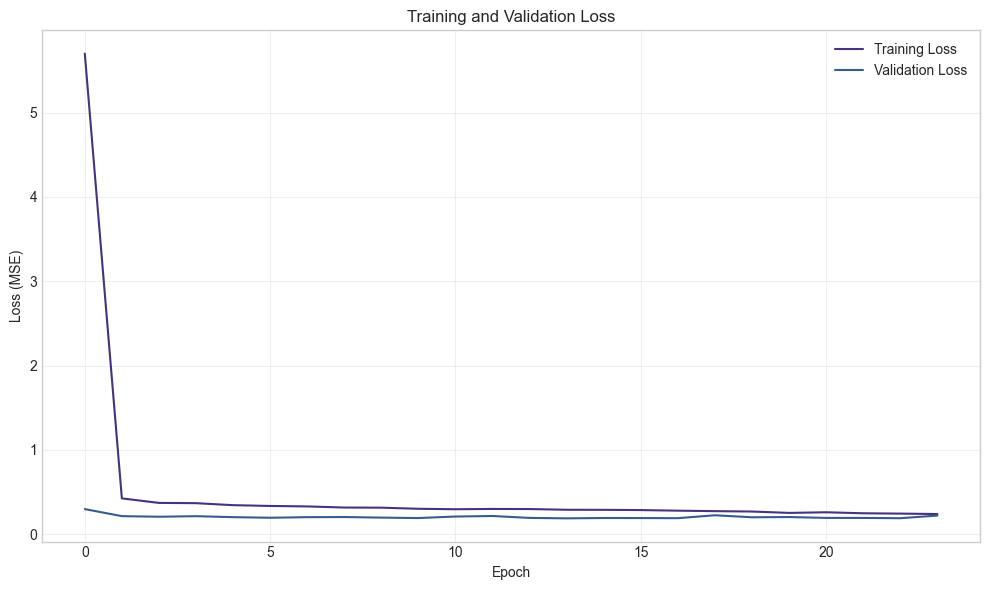

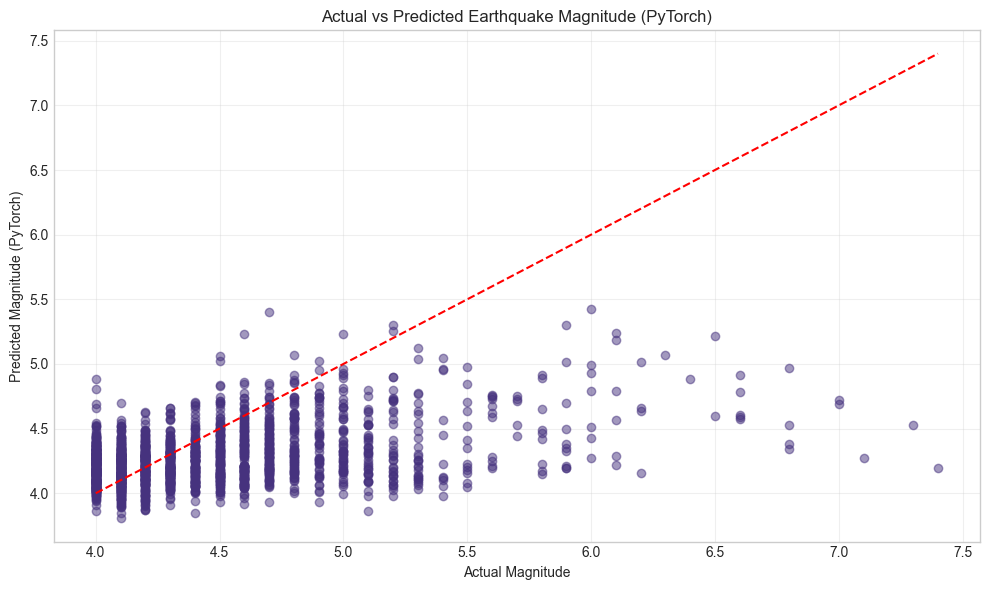

In [65]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Visualize actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_torch, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Magnitude')
plt.ylabel('Predicted Magnitude (PyTorch)')
plt.title('Actual vs Predicted Earthquake Magnitude (PyTorch)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [66]:
# Compare PyTorch with traditional model results
comparison_data = {
    'Model': ['PyTorch NN (GPU)', f'{best_model_name} (CPU)'],
    'MAE': [torch_mae, final_mae],
    'RMSE': [torch_rmse, final_rmse],
    'R²': [torch_r2, final_r2],
    'Training Time (s)': [gpu_training_time, None]  # We don't have CPU time recorded
}

comparison_df = pd.DataFrame(comparison_data)
print("Model Performance Comparison:")
comparison_df

Model Performance Comparison:


,Model,MAE,RMSE,R²,Training Time (s)
0,PyTorch NN (GPU),0.311968,0.468344,0.059200,10.205338
1,XGBoost (CPU),0.154498,0.230882,0.771362,NaN


In [67]:
# Save the PyTorch model
torch.save(model.state_dict(), 'models/earthquake_pytorch_model.pt')
print("PyTorch model saved as 'models/earthquake_pytorch_model.pt'")

# Also save a script to load and use the model
with open('models/load_pytorch_model.py', 'w') as f:
    f.write("""
import torch
import torch.nn as nn

class EarthquakeNN(nn.Module):
    def __init__(self, input_size):
        super(EarthquakeNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        return self.network(x)

# Function to load model
def load_model(model_path, input_size, device='cpu'):
    model = EarthquakeNN(input_size)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model
""")
print("Model loading script saved as 'models/load_pytorch_model.py'")

PyTorch model saved as 'models/earthquake_pytorch_model.pt'
Model loading script saved as 'models/load_pytorch_model.py'
